# Modeling Notebook

This notebook contains just the modeling process. Consult the EDA notebook for cleaning and exploration or the main notebook for the complete process.

In [1]:
import time
t0 = time.time()

In [2]:
# Warning: this notebook takes significant time (~40 minutes) to run given all the model training

import pandas as pd
import numpy as np
import code.data_preparation as dp
import code.visualizations as viz
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.utils import class_weight
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Activation, Bidirectional, GlobalMaxPool1D  
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.wrappers.scikit_learn import KerasClassifier
import pickle
import matplotlib.pyplot as plt
params = {'axes.titlesize': 20,
          'axes.labelsize' : 16,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'font.size': 14,
          'figure.figsize': (12, 8)}
plt.rcParams.update(params)

# Building a Baseline Model

Let's begin by dividing the data into test and training sets. We will try a few different approaches before we decide what model to tune including a naive bayesian classifier, a random forest model, and an RNN.

In [3]:
with open('data/clean_tweet_data.pickle', 'rb') as file:
    clean = pickle.load(file)

In [4]:
label = LabelEncoder()
X = clean['cleaned_text']
y = label.fit_transform(clean['is_there_an_emotion_directed_at_a_brand_or_product'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Naive Bayesian Classifier

A naive bayesian classifier run on a TF-IDF vectorizered version of the tweets with 1000 features has an accuracy of about 72% on the training and 66% on the test data, which is not amazing given how imbalanced the data is, and a weighted F1 score of 61% on test data.

In [5]:
tfidf = TfidfVectorizer(max_features=1000, stop_words=stopwords.words('english'))
X_train_vectorized = tfidf.fit_transform(X_train)
X_test_vectorized = tfidf.transform(X_test)

In [6]:
bayes_model = MultinomialNB()
bayes_cv = cross_val_score(bayes_model, X_train_vectorized, y_train)
bayes_cv

array([0.67628866, 0.6742268 , 0.6604811 , 0.66437414, 0.65749656])

In [7]:
bayes_model.fit(X_train_vectorized, y_train)

MultinomialNB()

In [8]:
dp.get_scores(bayes_model, X_train_vectorized, y_train)

{'Accuracy': 0.7155231678812044,
 'Precision': 0.7198648763481628,
 'Recall': 0.7155231678812044,
 'F1 Score': 0.6774593666283524}

In [9]:
dp.get_scores(bayes_model, X_test_vectorized, y_test)

{'Accuracy': 0.6608026388125343,
 'Precision': 0.677104303573336,
 'Recall': 0.6608026388125343,
 'F1 Score': 0.6126097298161581}

#### Training Confusion Matrix

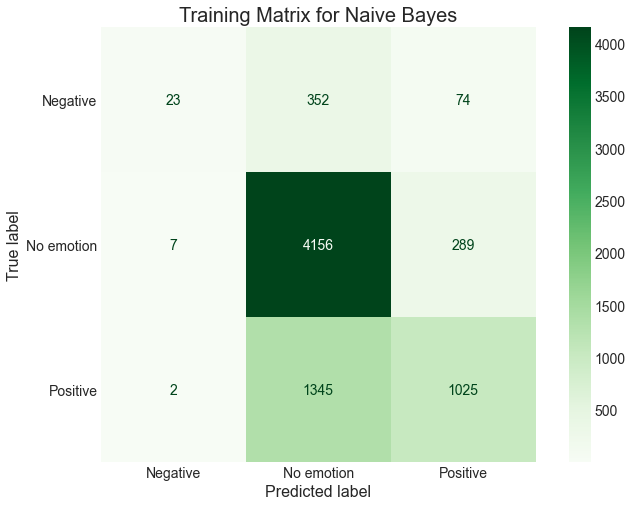

In [10]:
ConfusionMatrixDisplay.from_estimator(bayes_model, X_train_vectorized, y_train, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.title('Training Matrix for Naive Bayes')
plt.show()

#### Test Confusion Matrix

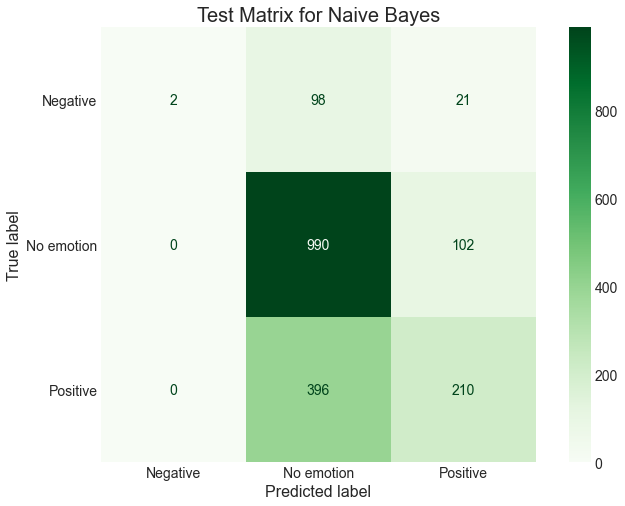

In [11]:
ConfusionMatrixDisplay.from_estimator(bayes_model, X_test_vectorized, y_test, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.title('Test Matrix for Naive Bayes')
plt.show()

Given the low prior probability of being in the negative catgory, we can see that the model is mostly just throwing things into the "no emotion category and completely ignoring the negative category. Clearly class imbalance is a big deal in this data.

### Random Forest

A baseline random forest classifier has an accuracy of about 98% on the training and 67% on the test data and an F1 score of 64% on test data.

In [12]:
forest_model = RandomForestClassifier()
forest_cv = cross_val_score(forest_model, X_train_vectorized, y_train)
forest_cv

array([0.66666667, 0.68522337, 0.65498282, 0.68225585, 0.6781293 ])

In [13]:
forest_model.fit(X_train_vectorized, y_train)

RandomForestClassifier()

In [14]:
dp.get_scores(forest_model, X_train_vectorized, y_train)

{'Accuracy': 0.9802007424721573,
 'Precision': 0.9803218605471105,
 'Recall': 0.9802007424721573,
 'F1 Score': 0.9801416275055241}

In [15]:
dp.get_scores(forest_model, X_test_vectorized, y_test)

{'Accuracy': 0.6641011544804838,
 'Precision': 0.6501341753637918,
 'Recall': 0.6641011544804838,
 'F1 Score': 0.6392438966228259}

#### Training Confusion Matrix

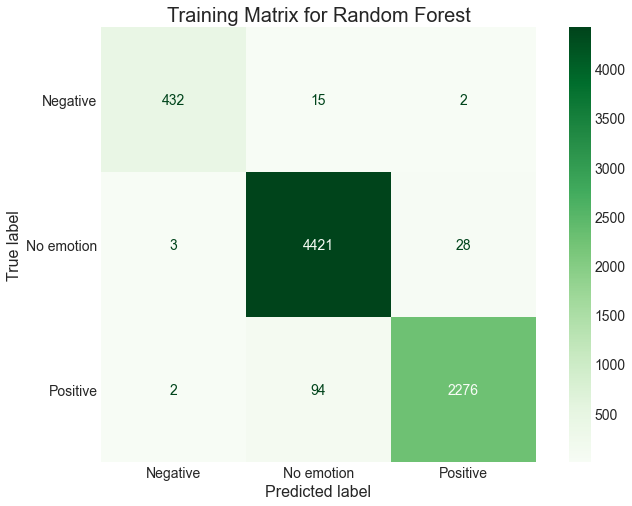

In [16]:
ConfusionMatrixDisplay.from_estimator(forest_model, X_train_vectorized, y_train, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.title('Training Matrix for Random Forest')
plt.show()

#### Test Confusion Matrix

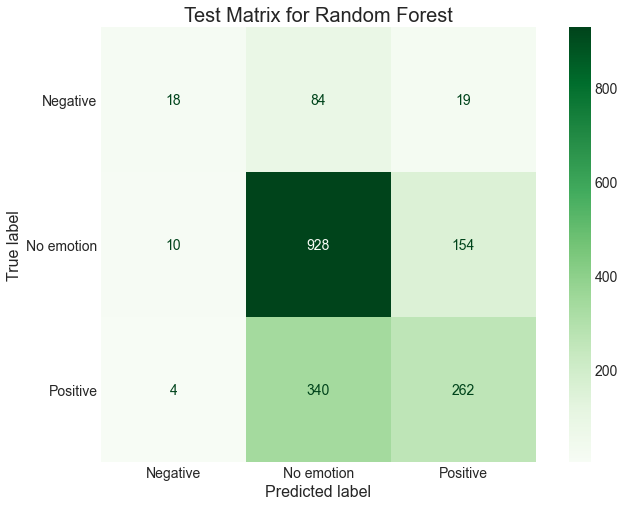

In [17]:
ConfusionMatrixDisplay.from_estimator(forest_model, X_test_vectorized, y_test, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.title('Test Matrix for Random Forest')
plt.show()

The random forest only does marginally better with the negative sentiment class. 

### Logisitic Regression

A basic logisic regression model has an accuracy of about 74% on the training data and 65% on the test data. I has an F1 score of about 62% on the test data.

In [18]:
logistic_model = LogisticRegression(max_iter=1000)
logistic_cv = cross_val_score(logistic_model, X_train_vectorized, y_train)
logistic_cv

array([0.68178694, 0.6790378 , 0.68041237, 0.67881706, 0.66712517])

In [19]:
logistic_model.fit(X_train_vectorized, y_train)

LogisticRegression(max_iter=1000)

In [20]:
dp.get_scores(logistic_model, X_train_vectorized, y_train)

{'Accuracy': 0.738759796507631,
 'Precision': 0.7417386840333267,
 'Recall': 0.738759796507631,
 'F1 Score': 0.7145163418253988}

In [21]:
dp.get_scores(logistic_model, X_test_vectorized, y_test)

{'Accuracy': 0.6520065970313359,
 'Precision': 0.6370186753272989,
 'Recall': 0.6520065970313359,
 'F1 Score': 0.6180878261470868}

#### Training Confusion Matrix

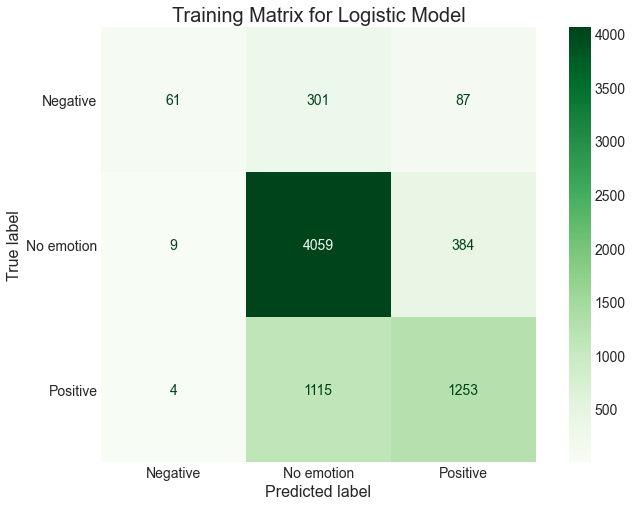

In [22]:
ConfusionMatrixDisplay.from_estimator(logistic_model, X_train_vectorized, y_train, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.title('Training Matrix for Logistic Model')
plt.show()

#### Test Confusion Matrix

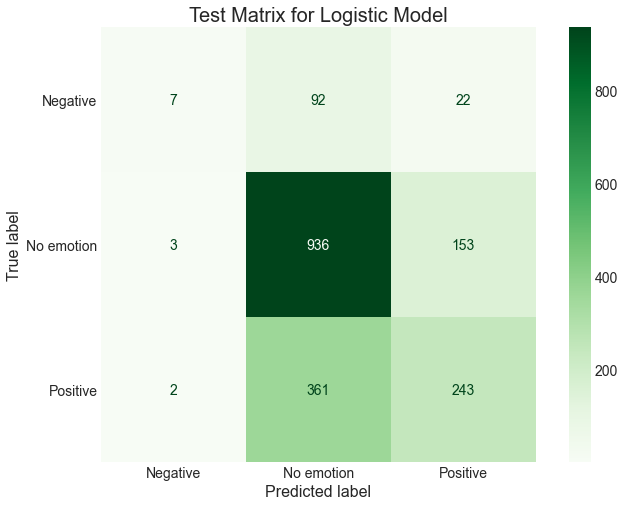

In [23]:
ConfusionMatrixDisplay.from_estimator(logistic_model, X_test_vectorized, y_test, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.title('Test Matrix for Logistic Model')
plt.show()

The logistic model, much like the bayesian is just assuming almost nothing goes in the negative class.

### Support Vector Machine

A basic support vector classifier model has an accuracy of about 85% on the training data and 68% on the test data. I has an F1 score of about 65% on the test data.

In [24]:
svm_model = SVC()
svm_cv = cross_val_score(svm_model, X_train_vectorized, y_train)
svm_cv

array([0.6838488 , 0.6975945 , 0.67147766, 0.69257221, 0.67881706])

In [25]:
svm_model.fit(X_train_vectorized, y_train)

SVC()

In [26]:
dp.get_scores(svm_model, X_train_vectorized, y_train)

{'Accuracy': 0.8545304551079335,
 'Precision': 0.8669527599021865,
 'Recall': 0.8545304551079335,
 'F1 Score': 0.844183729373784}

In [27]:
dp.get_scores(svm_model, X_test_vectorized, y_test)

{'Accuracy': 0.680593732820231,
 'Precision': 0.6908922947245612,
 'Recall': 0.680593732820231,
 'F1 Score': 0.6458559372484911}

#### Training Confusion Matrix

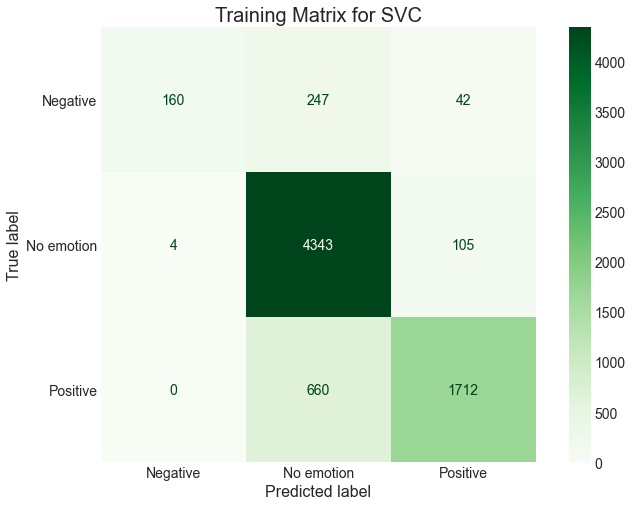

In [28]:
ConfusionMatrixDisplay.from_estimator(svm_model, X_train_vectorized, y_train, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.title('Training Matrix for SVC')
plt.show()

#### Test Confusion Matrix

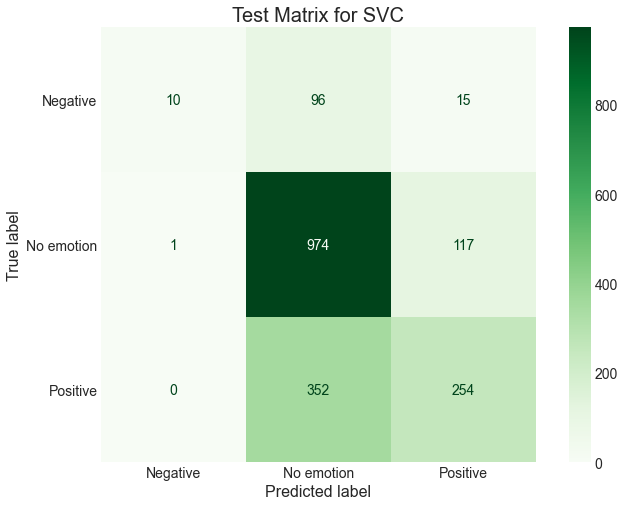

In [29]:
ConfusionMatrixDisplay.from_estimator(svm_model, X_test_vectorized, y_test, display_labels=label.classes_, cmap="Greens")
plt.grid(False)
plt.title('Test Matrix for SVC')
plt.show()

The SVM performs worse than the forest model on the negative data.

### Basic RNN

A neural nework with an embedding layer of 128, a LSTM layer with 25 nodes, and an additional dense layer of 50, with 50% drop out between layers trained for 5 epochs has an accuracy of about 87% on the training and 67% test data. I has an F1 score of about 87% on the training and 65% on the test data.

In [30]:
# Stopwords include things like 'not' which might be relevant to sentiment, 
# so we will just use the text cleaned of special characters, hashtags, and the like.
y_one_hot = pd.get_dummies(clean['is_there_an_emotion_directed_at_a_brand_or_product']).values
X_rnn = clean['cleaned_text']
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_rnn, y_one_hot, test_size=0.2, random_state=42)

In [31]:
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(X_train))
train_list_tokenized = tokenizer.texts_to_sequences(X_train_rnn)
X_train_padded = sequence.pad_sequences(train_list_tokenized, maxlen=100)
test_list_tokenized = tokenizer.texts_to_sequences(X_test_rnn)
X_test_padded = sequence.pad_sequences(test_list_tokenized, maxlen=100)

In [32]:
baseline_rnn = Sequential()
embedding_size = 128
baseline_rnn.add(Embedding(20000, embedding_size))
baseline_rnn.add(LSTM(50, return_sequences=True))
baseline_rnn.add(GlobalMaxPool1D())
baseline_rnn.add(Dropout(0.5))
baseline_rnn.add(Dense(50, activation='relu'))
baseline_rnn.add(Dropout(0.5))
baseline_rnn.add(Dense(3, activation='softmax'))

In [33]:
baseline_rnn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [34]:
baseline_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 lstm (LSTM)                 (None, None, 50)          35800     
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                        

In [35]:
baseline_rnn_val = baseline_rnn.fit(X_train_padded,
                                    y_train_rnn, 
                                    epochs=5, 
                                    batch_size=32, 
                                    validation_split=0.1)

Epoch 1/5
205/205 [==============================] - 13s 53ms/step - loss: 0.8913 - accuracy: 0.5762 - val_loss: 0.8107 - val_accuracy: 0.6511
Epoch 2/5
205/205 [==============================] - 10s 48ms/step - loss: 0.7992 - accuracy: 0.6312 - val_loss: 0.7072 - val_accuracy: 0.6745
Epoch 3/5
205/205 [==============================] - 10s 49ms/step - loss: 0.6254 - accuracy: 0.7451 - val_loss: 0.6954 - val_accuracy: 0.6868
Epoch 4/5
205/205 [==============================] - 10s 51ms/step - loss: 0.4671 - accuracy: 0.8243 - val_loss: 0.7164 - val_accuracy: 0.6813
Epoch 5/5
205/205 [==============================] - 10s 47ms/step - loss: 0.3619 - accuracy: 0.8625 - val_loss: 0.8899 - val_accuracy: 0.6758


In [36]:
baseline_rnn_val_dict = baseline_rnn_val.history

#### Metrics

This model is the most accurate and has the highest F1 of those tested.

In [37]:
baseline_metrics = dp.get_network_metrics(baseline_rnn, 
                                          X_train_padded, 
                                          y_train_rnn, 
                                          X_test_padded,
                                          y_test_rnn)

228/228 [==============================] - 2s 10ms/step - loss: 0.3092 - accuracy: 0.8837
----------
Training Loss: 0.309 
Training Accuracy: 0.884
Train Average Weighted F1 Score: 0.883
Train Recall on Rarest Category: 0.813
Train Precision on Rarest Category: 0.873
Train F1 on Rarest Category: 0.842
57/57 [==============================] - 1s 10ms/step - loss: 0.9469 - accuracy: 0.6647
----------
Test Loss: 0.947 
Test Accuracy: 0.665
Test Average Weighted F1 Score: 0.661
Test Recall on Rarest Category: 0.322
Test Precision on Rarest Category: 0.513
Test F1 on Rarest Category: 0.396


#### Confusion Matrices

We can see that the RNN does the best so far at classifying the negative examples.

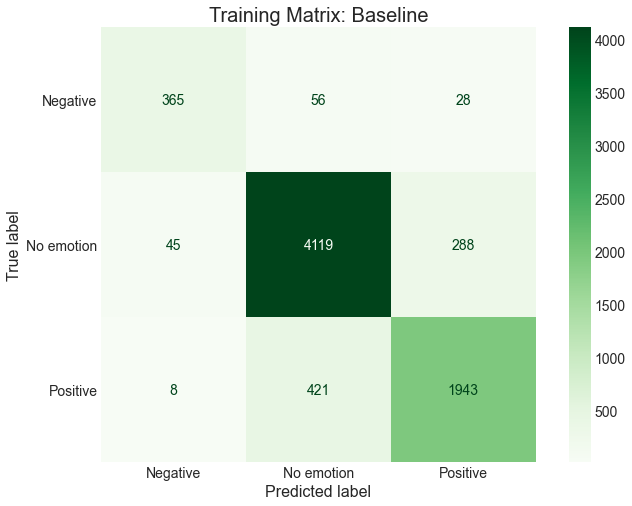

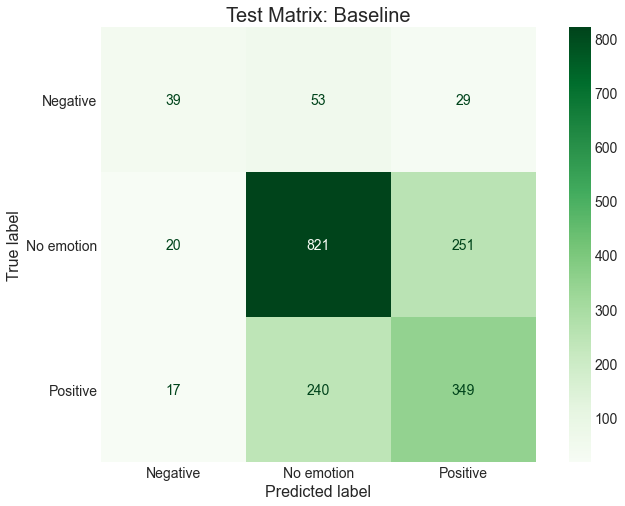

In [38]:
viz.make_network_confusion_matrices(baseline_rnn,
                                   X_train_padded,
                                   y_train_rnn,
                                   X_test_padded,
                                   y_test_rnn,
                                   labels = label.classes_,
                                   title = 'Baseline')

We can see from graphing the data, that the model starts significantly overfitting after about 3 epochs

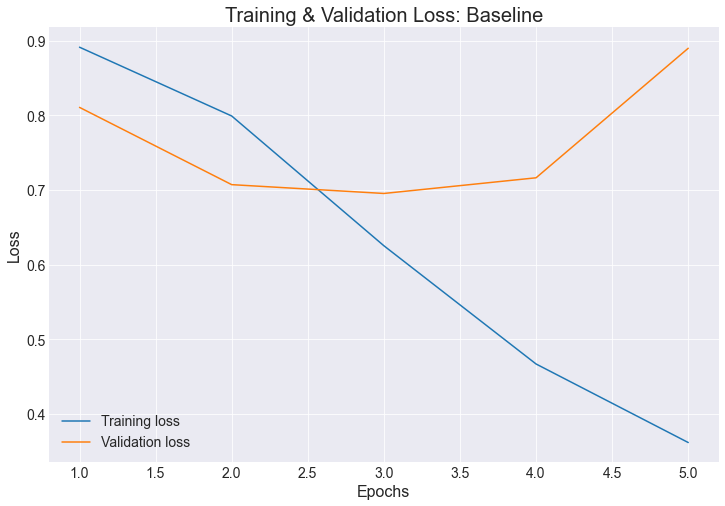

In [39]:
viz.training_graph(baseline_rnn_val_dict, 'Baseline')

### Augmenting the Data

Some of the issue seems to be arising from the limited data. One potential way we can augment text data is to use replacement with synonyms. This has the ability to create more tweets to train on while hopefully retaining the basic meaning enough that the target variables will still match.

In [40]:
import nlpaug.augmenter.word as naw

In [41]:
aug = naw.SynonymAug(aug_src='wordnet')
example = 'The quick brown fox jumps over the lazy dog'
augmented_example = aug.augment(example)
augmented_example

'The quick brown charles james fox jumps terminated the faineant dog'

In [42]:
X_train_to_augment = pd.DataFrame(X_train_rnn)
y_train_to_augment = pd.DataFrame(y_train_rnn)

In [43]:
y_train_to_augment.index = X_train_to_augment.index

In [44]:
augmented_train_data = X_train_to_augment.join(y_train_to_augment)

In [45]:
augmented_train_data.head(10)

cleaned_text  0  1  2
8256  in my next life i am coming back as an ipad 2 ...  0  0  1
6516  rt  rt  best thing i have heard this weekend a...  0  1  0
7256  i would love to meet u   rt  i will be at the ...  0  1  0
2116  iphone crashed in front of  apple pop up  best...  0  1  0
1545     platformer ci di venues  pake 3 app 4sq api...  0  1  0
5683  rt  do not forget  come to our q amp a with go...  0  1  0
7198   ouch  looks like i might be able to grab one ...  0  0  1
7494  google maps usage on mobile exceeded desktop u...  0  1  0
8516  from  marissa mayer  40  of google maps use mo...  0  0  1
8520  mom   quick   apply for a job  they need help ...  0  1  0

Below we can see some oddities emerging from sing the synonyms that will likely not be great for performance. For example, the "maps" in "Google maps" is replaced with "single value function" on index 7494.

In [46]:
augmented_train_data['cleaned_text'] = augmented_train_data['cleaned_text'].apply(lambda x: aug.augment(x))
augmented_train_data.head(10)

cleaned_text  0  1  2
8256  in my next animation i am coming rearwards as ...  0  0  1
6516  rt rt best thing i have heard this weekend at ...  0  1  0
7256  i would love to meet u rt i will exist at the ...  0  1  0
2116  iphone crashed in front of apple pop up bestwo...  0  1  0
1545  platformer curie di venues pake troika app 4sq...  0  1  0
5683  rt manage not forget come to our q amp a with ...  0  1  0
7198  ouch feeling like single might be capable to g...  0  0  1
7494  google function exercise on mobile outstrip de...  0  1  0
8516  from marissa louis b. mayer xl of google mappi...  0  0  1
8520  momma warm apply for a book of job they take f...  0  1  0

In [47]:
X_train_augmented = pd.concat([X_train_rnn, augmented_train_data['cleaned_text']])
X_train_augmented.shape

(14546,)

In [48]:
y_train_augmented = pd.concat([y_train_to_augment, augmented_train_data[[0,1,2]]])
y_train_augmented = np.array(y_train_augmented)
y_train_augmented.shape

(14546, 3)

#### Running the Baseline RNN on Augmented Data

Although there may be issues in augmenting the data in this way, let's test it before we give up on this attempt.

In [49]:
aug_tokenizer = text.Tokenizer(num_words=20000)
aug_tokenizer.fit_on_texts(list(X_train_augmented))
aug_train_list_tokenized = aug_tokenizer.texts_to_sequences(X_train_augmented)
X_train_augmented_padded = sequence.pad_sequences(aug_train_list_tokenized, maxlen=100)
aug_test_list_tokenized = aug_tokenizer.texts_to_sequences(X_test_rnn)
X_test_augmented_padded = sequence.pad_sequences(aug_test_list_tokenized, maxlen=100)
y_test_augmented = y_test_rnn.copy()

In [50]:
augmented_rnn = Sequential()
embedding_size = 128
augmented_rnn.add(Embedding(20000, embedding_size))
augmented_rnn.add(LSTM(50, return_sequences=True))
augmented_rnn.add(GlobalMaxPool1D())
augmented_rnn.add(Dropout(0.5))
augmented_rnn.add(Dense(50, activation='relu'))
augmented_rnn.add(Dropout(0.5))
augmented_rnn.add(Dense(3, activation='softmax'))
augmented_rnn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [51]:
augmented_rnn_val = augmented_rnn.fit(X_train_augmented_padded, 
                                      y_train_augmented,
                                      epochs=5, 
                                      batch_size=32, 
                                      validation_split=0.1)

Epoch 1/5
410/410 [==============================] - 22s 51ms/step - loss: 0.8351 - accuracy: 0.6195 - val_loss: 0.7114 - val_accuracy: 0.6873
Epoch 2/5
410/410 [==============================] - 20s 49ms/step - loss: 0.6034 - accuracy: 0.7596 - val_loss: 0.5507 - val_accuracy: 0.7663
Epoch 3/5
410/410 [==============================] - 21s 50ms/step - loss: 0.4029 - accuracy: 0.8465 - val_loss: 0.4826 - val_accuracy: 0.7986
Epoch 4/5
410/410 [==============================] - 23s 56ms/step - loss: 0.2922 - accuracy: 0.8908 - val_loss: 0.4915 - val_accuracy: 0.8007
Epoch 5/5
410/410 [==============================] - 19s 47ms/step - loss: 0.2327 - accuracy: 0.9138 - val_loss: 0.5084 - val_accuracy: 0.8151


One concern about augmenting the data in this way is that the validation scores are a less reliable test for overfitting because there are essentially duplicate tweets in both sets, and there doesn't seem to be any improvement on test data likely because it is easier for the network to over fit on the training examples.

In [52]:
augmented_rnn_val_dict = augmented_rnn_val.history

In [53]:
augmented_metrics = dp.get_network_metrics(augmented_rnn, 
                                          X_train_augmented_padded, 
                                          y_train_augmented, 
                                          X_test_augmented_padded,
                                          y_test_augmented)

455/455 [==============================] - 5s 10ms/step - loss: 0.1756 - accuracy: 0.9354
----------
Training Loss: 0.176 
Training Accuracy: 0.935
Train Average Weighted F1 Score: 0.935
Train Recall on Rarest Category: 0.916
Train Precision on Rarest Category: 0.929
Train F1 on Rarest Category: 0.923
57/57 [==============================] - 1s 10ms/step - loss: 1.2967 - accuracy: 0.6614
----------
Test Loss: 1.3 
Test Accuracy: 0.661
Test Average Weighted F1 Score: 0.657
Test Recall on Rarest Category: 0.314
Test Precision on Rarest Category: 0.463
Test F1 on Rarest Category: 0.374


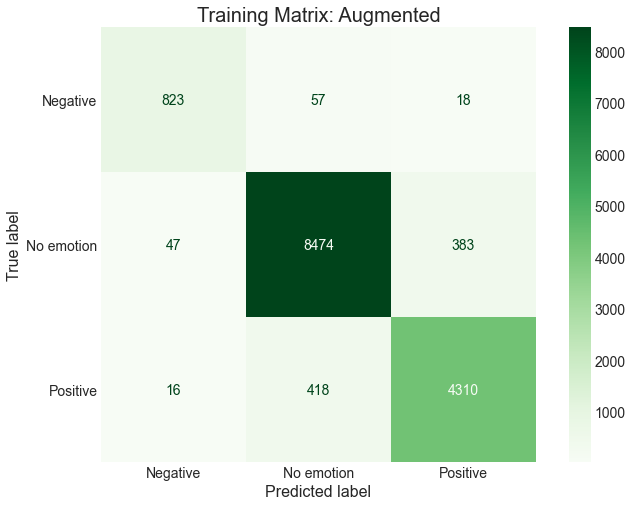

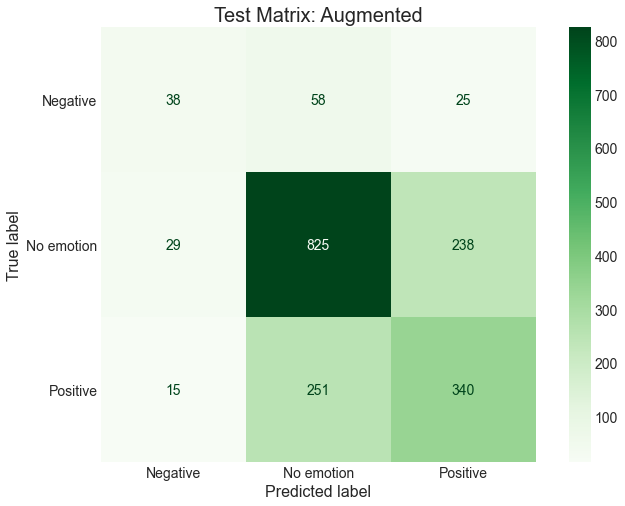

In [54]:
viz.make_network_confusion_matrices(augmented_rnn,
                                   X_train_augmented_padded,
                                   y_train_augmented,
                                   X_test_augmented_padded,
                                   y_test_augmented,
                                   labels = label.classes_,
                                   title = 'Augmented')

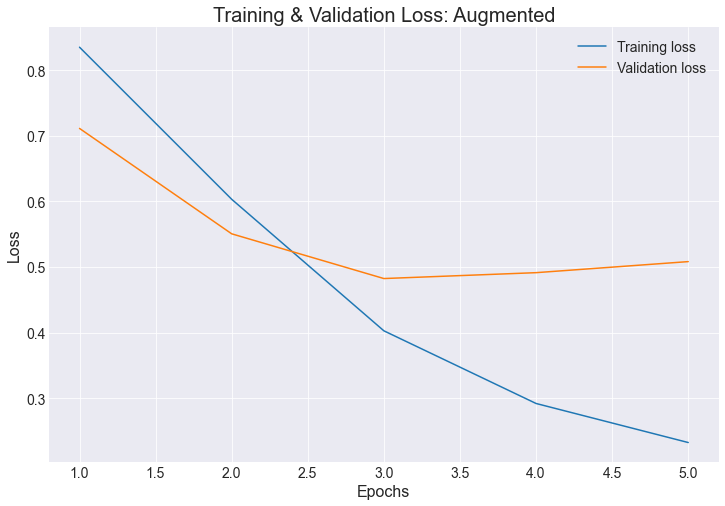

In [55]:
viz.training_graph(augmented_rnn_val_dict, 'Augmented')

Given that there was no improvement with augmenting over baseline we will preceed using just the original data, since it makes the validation scores more interpretable.

## Tuning the Model

### *Dealing with Class Imbalance*

One clear issue is the major class imbalance particularly with the negative sentiment data being so rare in this particular dataset. Maybe gathering data from the #SXSW tag was a bad idea if you want a representative sample of sentiment, but we have to deal with the data we have.

We might attempt to make a weighted  model or oversample the data to deal with it, but oversampling isn't particularly useful with text data since it just duplicates the tweets at best and could make nonsense at worst, so we wll just weight the data.

Let's go with the RNN since that performed the best anyway.

In [56]:
y_integers = np.argmax(y_train_rnn, axis=1)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: 5.399406087602078, 1: 0.5445492662473794, 2: 1.0220629567172568}

In [57]:
weighted_rnn = Sequential()
embedding_size = 128
weighted_rnn.add(Embedding(20000, embedding_size))
weighted_rnn.add(LSTM(50, return_sequences=True))
weighted_rnn.add(GlobalMaxPool1D())
weighted_rnn.add(Dropout(0.5))
weighted_rnn.add(Dense(50, activation='relu'))
weighted_rnn.add(Dropout(0.5))
weighted_rnn.add(Dense(3, activation='softmax'))
weighted_rnn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [58]:
weighted_rnn_val = weighted_rnn.fit(X_train_padded,
                                    y_train_rnn,
                                    epochs=5,
                                    batch_size=32,
                                    validation_split=0.1, 
                                    class_weight= d_class_weights)

Epoch 1/5
205/205 [==============================] - 12s 51ms/step - loss: 1.1024 - accuracy: 0.3433 - val_loss: 1.0355 - val_accuracy: 0.6016
Epoch 2/5
205/205 [==============================] - 10s 48ms/step - loss: 0.9697 - accuracy: 0.5172 - val_loss: 0.9662 - val_accuracy: 0.5357
Epoch 3/5
205/205 [==============================] - 10s 47ms/step - loss: 0.6765 - accuracy: 0.6851 - val_loss: 0.8302 - val_accuracy: 0.6346
Epoch 4/5
205/205 [==============================] - 10s 46ms/step - loss: 0.4704 - accuracy: 0.7931 - val_loss: 0.9058 - val_accuracy: 0.6030
Epoch 5/5
205/205 [==============================] - 10s 47ms/step - loss: 0.3746 - accuracy: 0.8327 - val_loss: 0.9597 - val_accuracy: 0.6209


In [59]:
weighted_rnn_val_dict = weighted_rnn_val.history

#### Metrics

The weighted model has worse performance on accuracy and F1 score, but has significant gains for the rare category.

In [60]:
weighted_metrics = dp.get_network_metrics(weighted_rnn, 
                                          X_train_padded, 
                                          y_train_rnn, 
                                          X_test_padded,
                                          y_test_rnn)

228/228 [==============================] - 2s 10ms/step - loss: 0.4064 - accuracy: 0.8412
----------
Training Loss: 0.406 
Training Accuracy: 0.841
Train Average Weighted F1 Score: 0.844
Train Recall on Rarest Category: 0.944
Train Precision on Rarest Category: 0.688
Train F1 on Rarest Category: 0.796
57/57 [==============================] - 1s 10ms/step - loss: 1.0019 - accuracy: 0.6201
----------
Test Loss: 1.0 
Test Accuracy: 0.62
Test Average Weighted F1 Score: 0.628
Test Recall on Rarest Category: 0.471
Test Precision on Rarest Category: 0.365
Test F1 on Rarest Category: 0.412


#### Confusion Matrices

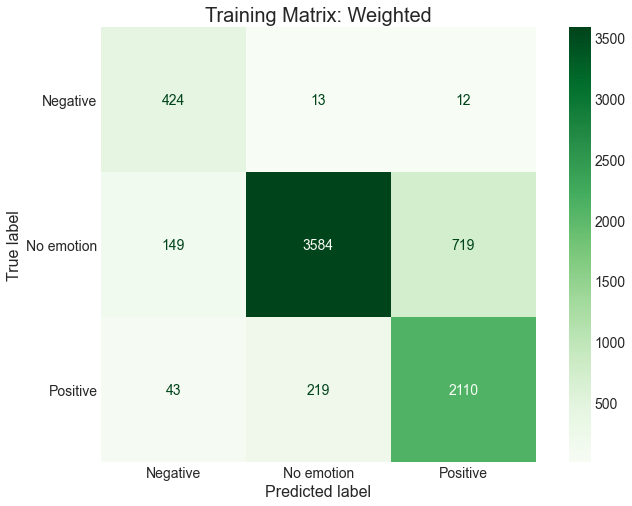

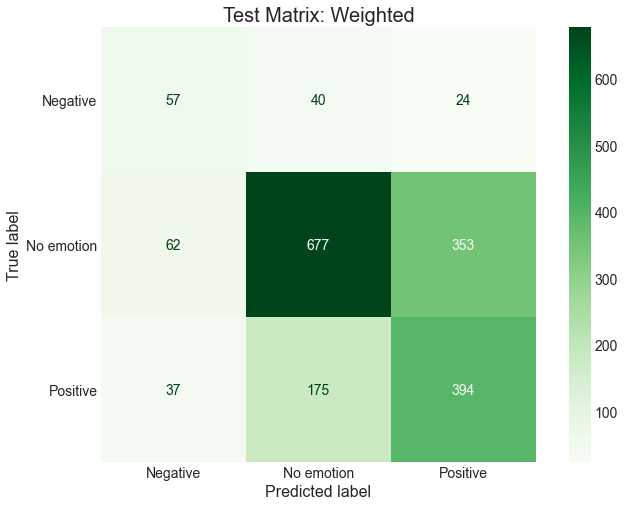

In [61]:
viz.make_network_confusion_matrices(weighted_rnn,
                                   X_train_padded,
                                   y_train_rnn,
                                   X_test_padded,
                                   y_test_rnn,
                                   labels = label.classes_,
                                   title = 'Weighted')

The weighted model is also showing significant signs of overfitting after just three training epochs.

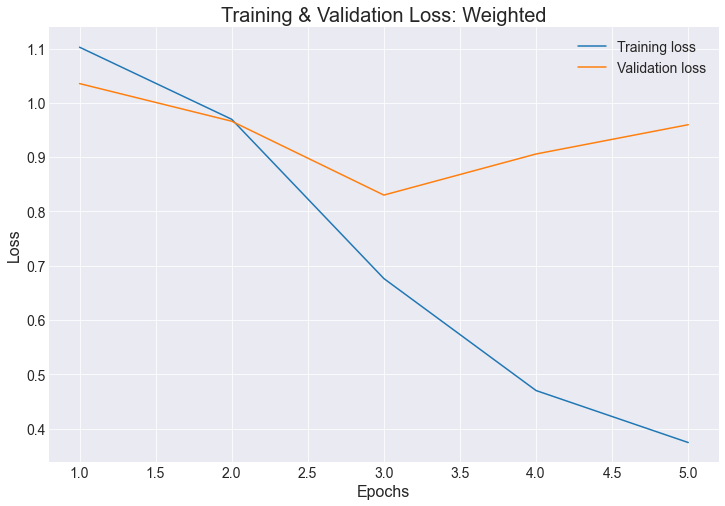

In [62]:
viz.training_graph(weighted_rnn_val_dict, 'Weighted')

### *Using GloVe Embeddeding*

One way we might attempt to improve the model's performance is to use a pretrained embedding rather than training one within the model. GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. It can be found here: https://nlp.stanford.edu/projects/glove/

To begin we will collect the parts of the GloVe vector relevant to our data.

In [63]:
word_index = tokenizer.word_index
print('There are {} unique tokens in the dataset.'.format(len(word_index)))

There are 8813 unique tokens in the dataset.


In [64]:
glove = {}
with open('glove.twitter.27B.100d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in word_index.keys():
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [65]:
glove['love']

array([-4.8371e-01, -2.7318e-01, -4.6840e-02,  7.0274e-01, -5.6301e-01,
       -1.7214e-01,  8.1775e-01, -6.6641e-02,  2.0224e-02, -2.3878e-01,
       -1.6122e-02, -1.7875e-01, -4.9281e+00, -4.0272e-01, -4.1190e-01,
       -1.4570e-01,  1.8508e-01, -1.9116e-01, -8.4608e-01,  6.5378e-01,
        1.2370e-01,  4.8835e-02, -3.3709e-01,  2.5834e-01,  4.7729e-01,
       -8.8145e-01, -1.3083e-01,  7.9499e-01,  8.6216e-02, -9.1803e-01,
       -9.6671e-01, -4.8309e-01, -4.0963e-01,  1.6920e-01,  2.3241e-01,
       -2.0524e-02,  2.2267e-01, -2.6763e-01,  1.4378e-01, -4.6547e-02,
       -1.1726e+00, -3.5298e-02,  2.8347e-01,  4.3446e-01,  1.8472e-01,
        3.3065e-01,  6.7848e-02, -7.6485e-01,  1.8351e-01, -6.4361e-01,
       -7.5015e-01, -4.2583e-02,  2.4262e-01, -6.4108e-01,  6.9741e-01,
       -2.3133e-01, -2.1454e-01,  3.1040e-01,  2.3161e-01,  6.8397e-02,
        8.1428e-02, -3.9331e-01, -1.0927e+00, -4.2618e-02, -9.6970e-02,
        3.1243e-01, -1.0463e+00,  2.8207e-01, -7.2446e-01,  3.14

We will next construct an embedding martrix, so we can use the GloVe vectors in an embedding layer.

In [66]:
embedding_matrix = np.zeros((len(word_index) + 1, 100)) # 100 dimensions since we used 100 dimensional glove vectors
for word, i in word_index.items():
    embedding_vector = glove.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Next, we will make the embedding layer. It will be untrainable, since we want to retain the information from the pretrained vectors.

In [67]:
embedding_layer = Embedding(len(word_index) + 1,
                            100,
                            weights=[embedding_matrix],
                            input_length=100,
                            trainable=False)

In [68]:
glove_rnn = Sequential()
glove_rnn.add(embedding_layer)
glove_rnn.add(LSTM(50, return_sequences=True))
glove_rnn.add(GlobalMaxPool1D())
glove_rnn.add(Dropout(0.5))
glove_rnn.add(Dense(50, activation='relu'))
glove_rnn.add(Dropout(0.5))
glove_rnn.add(Dense(3, activation='softmax'))
glove_rnn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [69]:
glove_rnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          881400    
                                                                 
 lstm_3 (LSTM)               (None, 100, 50)           30200     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 50)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 50)                2550      
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                      

The GloVe model will take more training epoches to reach the same score since it has less nodes to vary during training.

In [70]:
glove_rnn_val = glove_rnn.fit(X_train_padded,
                              y_train_rnn,
                              epochs=20,
                              batch_size=32,
                              validation_split=0.1)                            

Epoch 1/20
205/205 [==============================] - 8s 29ms/step - loss: 0.8956 - accuracy: 0.5788 - val_loss: 0.7855 - val_accuracy: 0.6511
Epoch 2/20
205/205 [==============================] - 6s 27ms/step - loss: 0.8443 - accuracy: 0.6070 - val_loss: 0.7627 - val_accuracy: 0.6511
Epoch 3/20
205/205 [==============================] - 6s 27ms/step - loss: 0.8081 - accuracy: 0.6220 - val_loss: 0.7430 - val_accuracy: 0.6745
Epoch 4/20
205/205 [==============================] - 6s 27ms/step - loss: 0.7854 - accuracy: 0.6353 - val_loss: 0.7224 - val_accuracy: 0.6937
Epoch 5/20
205/205 [==============================] - 6s 27ms/step - loss: 0.7575 - accuracy: 0.6527 - val_loss: 0.7120 - val_accuracy: 0.7143
Epoch 6/20
205/205 [==============================] - 6s 27ms/step - loss: 0.7365 - accuracy: 0.6643 - val_loss: 0.6993 - val_accuracy: 0.7019
Epoch 7/20
205/205 [==============================] - 6s 28ms/step - loss: 0.7135 - accuracy: 0.6770 - val_loss: 0.6812 - val_accuracy: 0.6813

In [71]:
glove_rnn_val_dict = glove_rnn_val.history

#### Metrics

There is a marginal improvement in the F1 score over the baseline model. The GloVe model also performs a bit better on the negative data than the baseline model, but a lot worse than the weighted model.

In [72]:
glove_metrics = dp.get_network_metrics(glove_rnn, 
                                          X_train_padded, 
                                          y_train_rnn, 
                                          X_test_padded,
                                          y_test_rnn) 

228/228 [==============================] - 2s 10ms/step - loss: 0.4791 - accuracy: 0.8078
----------
Training Loss: 0.479 
Training Accuracy: 0.808
Train Average Weighted F1 Score: 0.805
Train Recall on Rarest Category: 0.586
Train Precision on Rarest Category: 0.756
Train F1 on Rarest Category: 0.66
57/57 [==============================] - 1s 10ms/step - loss: 0.7223 - accuracy: 0.6894
----------
Test Loss: 0.722 
Test Accuracy: 0.689
Test Average Weighted F1 Score: 0.683
Test Recall on Rarest Category: 0.281
Test Precision on Rarest Category: 0.557
Test F1 on Rarest Category: 0.374


#### Confusion Matrices

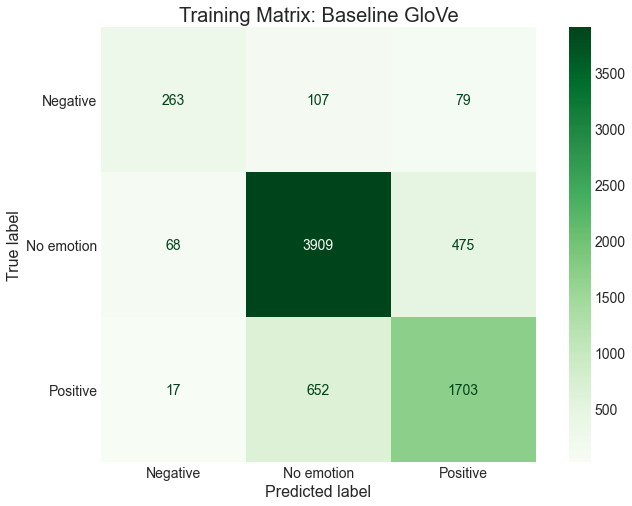

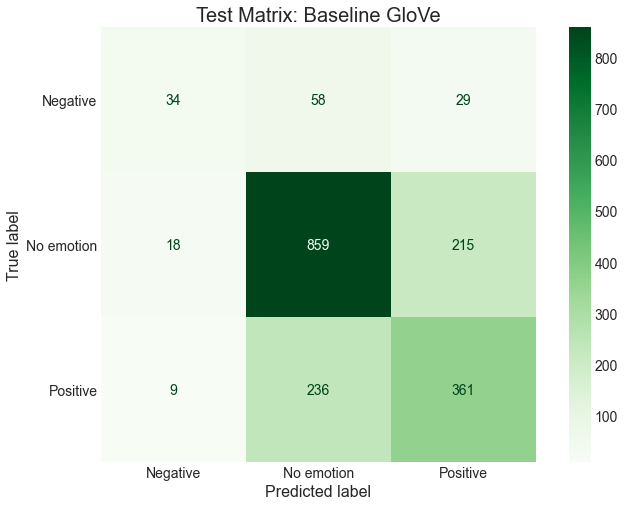

In [73]:
viz.make_network_confusion_matrices(glove_rnn,
                                   X_train_padded,
                                   y_train_rnn,
                                   X_test_padded,
                                   y_test_rnn,
                                   labels = label.classes_,
                                   title = 'Baseline GloVe')

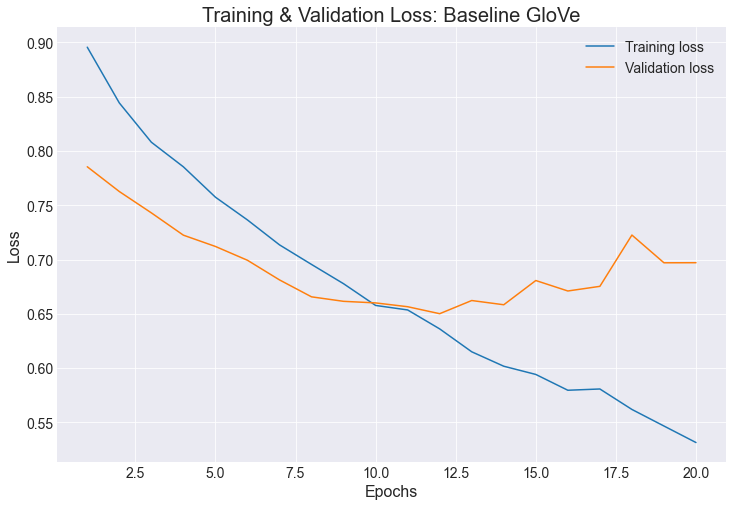

In [74]:
viz.training_graph(glove_rnn_val_dict, 'Baseline GloVe')

### *Weighted GloVe*

In [75]:
wglove_rnn = Sequential()
wglove_rnn.add(embedding_layer)
wglove_rnn.add(LSTM(50, return_sequences=True))
wglove_rnn.add(GlobalMaxPool1D())
wglove_rnn.add(Dropout(0.5))
wglove_rnn.add(Dense(50, activation='relu'))
wglove_rnn.add(Dropout(0.5))
wglove_rnn.add(Dense(3, activation='softmax'))
wglove_rnn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [76]:
wglove_rnn_val = wglove_rnn.fit(X_train_padded,
                                y_train_rnn,
                                epochs=23,
                                batch_size=32,
                                validation_split=0.1,
                                class_weight= d_class_weights)    

Epoch 1/23
205/205 [==============================] - 7s 28ms/step - loss: 1.1027 - accuracy: 0.3985 - val_loss: 1.0150 - val_accuracy: 0.5687
Epoch 2/23
205/205 [==============================] - 5s 27ms/step - loss: 1.0346 - accuracy: 0.4523 - val_loss: 1.0152 - val_accuracy: 0.5027
Epoch 3/23
205/205 [==============================] - 5s 27ms/step - loss: 0.9745 - accuracy: 0.4848 - val_loss: 0.9315 - val_accuracy: 0.5467
Epoch 4/23
205/205 [==============================] - 5s 26ms/step - loss: 0.9295 - accuracy: 0.5244 - val_loss: 1.0713 - val_accuracy: 0.4931
Epoch 5/23
205/205 [==============================] - 5s 26ms/step - loss: 0.8894 - accuracy: 0.5456 - val_loss: 0.8079 - val_accuracy: 0.6319
Epoch 6/23
205/205 [==============================] - 5s 27ms/step - loss: 0.8630 - accuracy: 0.5624 - val_loss: 0.8269 - val_accuracy: 0.6140
Epoch 7/23
205/205 [==============================] - 6s 27ms/step - loss: 0.8349 - accuracy: 0.5756 - val_loss: 0.8699 - val_accuracy: 0.5591

In [77]:
wglove_rnn_val_dict = wglove_rnn_val.history

#### Metrics

The weights substantially lowered the accuracy and F1 scores. It did improve the performance on negative data significantly over the unweighted GloVe model, but has a lower recall than the baseline weighted model.

In [78]:
wglove_metrics = dp.get_network_metrics(wglove_rnn, 
                                          X_train_padded, 
                                          y_train_rnn, 
                                          X_test_padded,
                                          y_test_rnn)

228/228 [==============================] - 2s 9ms/step - loss: 0.5761 - accuracy: 0.7323
----------
Training Loss: 0.576 
Training Accuracy: 0.732
Train Average Weighted F1 Score: 0.736
Train Recall on Rarest Category: 0.947
Train Precision on Rarest Category: 0.605
Train F1 on Rarest Category: 0.738
57/57 [==============================] - 1s 10ms/step - loss: 0.8420 - accuracy: 0.6157
----------
Test Loss: 0.842 
Test Accuracy: 0.616
Test Average Weighted F1 Score: 0.624
Test Recall on Rarest Category: 0.545
Test Precision on Rarest Category: 0.388
Test F1 on Rarest Category: 0.454


#### Confusion Matrices

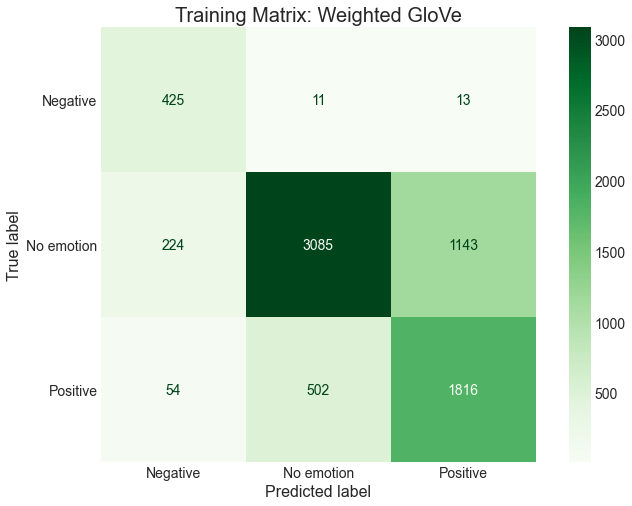

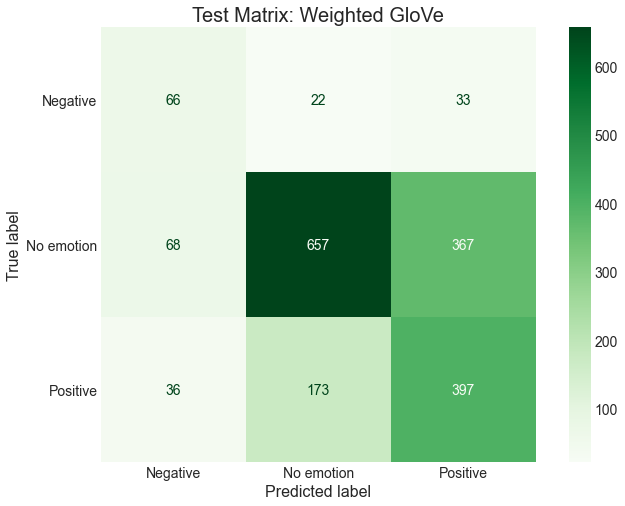

In [79]:
viz.make_network_confusion_matrices(wglove_rnn,
                                   X_train_padded,
                                   y_train_rnn,
                                   X_test_padded,
                                   y_test_rnn,
                                   labels = label.classes_,
                                   title = 'Weighted GloVe')

There are signs of overfitting around 15 epochs and the drop in the validation score is more stochastic using the weighted data.

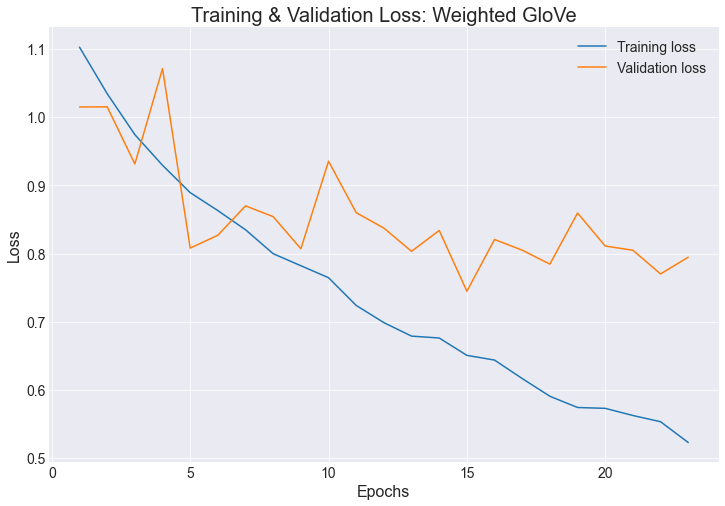

In [80]:
viz.training_graph(wglove_rnn_val_dict, 'Weighted GloVe')

### *Altering Nodes to RNN Layer of GloVe Model*

Let's begin by testing to see if increasing the number LSTM layer nodes and decrease training to 5 epochs has any noticable effect.

In [81]:
more_lstm_rnn = Sequential()
embedding_size = 128
more_lstm_rnn.add(embedding_layer)
more_lstm_rnn.add(LSTM(100, return_sequences=True))
more_lstm_rnn.add(GlobalMaxPool1D())
more_lstm_rnn.add(Dropout(0.5))
more_lstm_rnn.add(Dense(50, activation='relu'))
more_lstm_rnn.add(Dropout(0.5))
more_lstm_rnn.add(Dense(3, activation='softmax'))
more_lstm_rnn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [82]:
more_lstm_rnn_val = more_lstm_rnn.fit(X_train_padded,
                                      y_train_rnn,
                                      epochs=12, 
                                      batch_size=32,
                                      validation_split=0.1)

Epoch 1/12
205/205 [==============================] - 10s 44ms/step - loss: 0.8823 - accuracy: 0.5873 - val_loss: 0.7730 - val_accuracy: 0.6511
Epoch 2/12
205/205 [==============================] - 9s 42ms/step - loss: 0.8140 - accuracy: 0.6162 - val_loss: 0.7386 - val_accuracy: 0.6635
Epoch 3/12
205/205 [==============================] - 9s 42ms/step - loss: 0.7907 - accuracy: 0.6298 - val_loss: 0.7268 - val_accuracy: 0.6882
Epoch 4/12
205/205 [==============================] - 9s 42ms/step - loss: 0.7515 - accuracy: 0.6585 - val_loss: 0.7034 - val_accuracy: 0.6964
Epoch 5/12
205/205 [==============================] - 9s 43ms/step - loss: 0.7300 - accuracy: 0.6675 - val_loss: 0.6813 - val_accuracy: 0.7005
Epoch 6/12
205/205 [==============================] - 9s 42ms/step - loss: 0.7040 - accuracy: 0.6758 - val_loss: 0.6889 - val_accuracy: 0.6827
Epoch 7/12
205/205 [==============================] - 9s 42ms/step - loss: 0.6859 - accuracy: 0.6921 - val_loss: 0.6636 - val_accuracy: 0.707

In [83]:
more_lstm_rnn_val_dict = more_lstm_rnn_val.history

#### Metrics

This model does very similar on F1 score and accuracy to the initial GloVe model. This model does better on the rare negative data than the initial GloVe model.

In [84]:
more_lstm_metrics = dp.get_network_metrics(more_lstm_rnn, 
                                          X_train_padded, 
                                          y_train_rnn, 
                                          X_test_padded,
                                          y_test_rnn)

228/228 [==============================] - 4s 17ms/step - loss: 0.5199 - accuracy: 0.7740
----------
Training Loss: 0.52 
Training Accuracy: 0.774
Train Average Weighted F1 Score: 0.768
Train Recall on Rarest Category: 0.528
Train Precision on Rarest Category: 0.608
Train F1 on Rarest Category: 0.565
57/57 [==============================] - 1s 16ms/step - loss: 0.7033 - accuracy: 0.6938
----------
Test Loss: 0.703 
Test Accuracy: 0.694
Test Average Weighted F1 Score: 0.682
Test Recall on Rarest Category: 0.347
Test Precision on Rarest Category: 0.56
Test F1 on Rarest Category: 0.429


#### Confusion Matrices

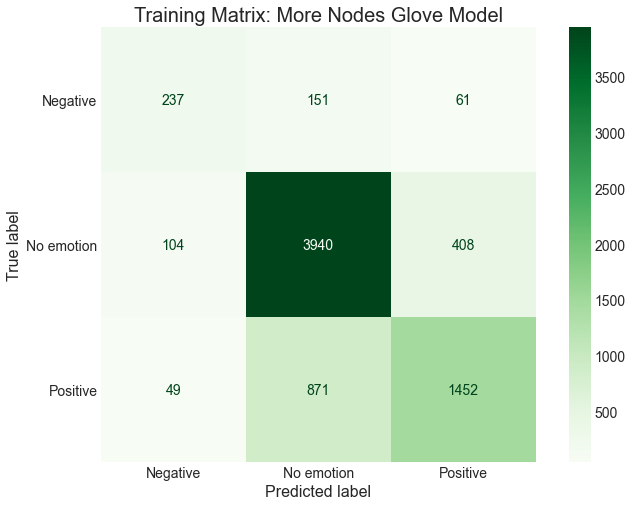

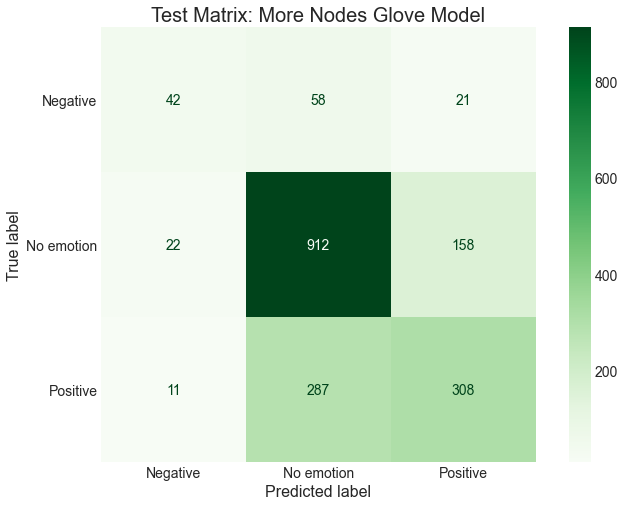

In [85]:
viz.make_network_confusion_matrices(more_lstm_rnn,
                                   X_train_padded,
                                   y_train_rnn,
                                   X_test_padded,
                                   y_test_rnn,
                                   labels = label.classes_,
                                   title = 'More Nodes Glove Model')

There are clear signs of overfitting in the plateau of the validation scores.

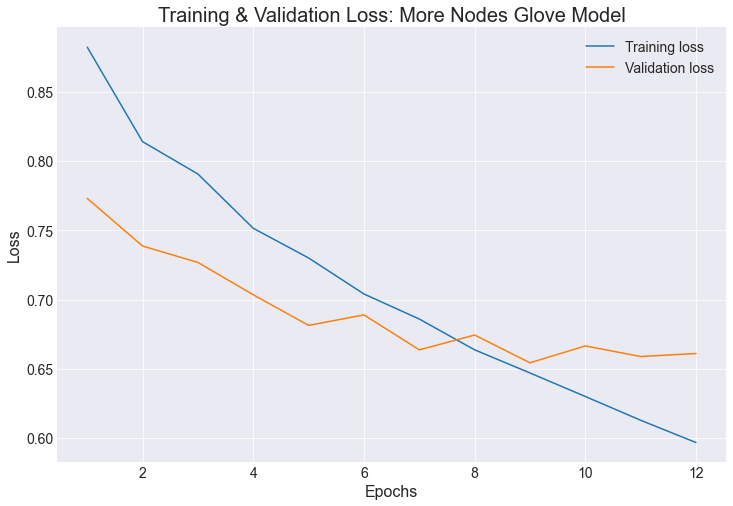

In [86]:
viz.training_graph(more_lstm_rnn_val_dict, 'More Nodes Glove Model')

### *Adding Weighting*

In [87]:
w_more_lstm_rnn = Sequential()
embedding_size = 128
w_more_lstm_rnn.add(embedding_layer)
w_more_lstm_rnn.add(LSTM(100, return_sequences=True))
w_more_lstm_rnn.add(GlobalMaxPool1D())
w_more_lstm_rnn.add(Dropout(0.5))
w_more_lstm_rnn.add(Dense(50, activation='relu'))
w_more_lstm_rnn.add(Dropout(0.5))
w_more_lstm_rnn.add(Dense(3, activation='softmax'))
w_more_lstm_rnn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [88]:
w_more_lstm_rnn_val = w_more_lstm_rnn.fit(X_train_padded,
                                          y_train_rnn,
                                          epochs=20, 
                                          batch_size=64,
                                          validation_split=0.1,
                                          class_weight = d_class_weights)

Epoch 1/20
103/103 [==============================] - 8s 65ms/step - loss: 1.1111 - accuracy: 0.3931 - val_loss: 1.0871 - val_accuracy: 0.3997
Epoch 2/20
103/103 [==============================] - 7s 63ms/step - loss: 1.0351 - accuracy: 0.4098 - val_loss: 0.9428 - val_accuracy: 0.5330
Epoch 3/20
103/103 [==============================] - 6s 62ms/step - loss: 0.9922 - accuracy: 0.4678 - val_loss: 1.0991 - val_accuracy: 0.4038
Epoch 4/20
103/103 [==============================] - 6s 62ms/step - loss: 0.9319 - accuracy: 0.4984 - val_loss: 0.9639 - val_accuracy: 0.5110
Epoch 5/20
103/103 [==============================] - 6s 62ms/step - loss: 0.8932 - accuracy: 0.5279 - val_loss: 0.8164 - val_accuracy: 0.6195
Epoch 6/20
103/103 [==============================] - 6s 63ms/step - loss: 0.8502 - accuracy: 0.5406 - val_loss: 1.0502 - val_accuracy: 0.4945
Epoch 7/20
103/103 [==============================] - 7s 63ms/step - loss: 0.8214 - accuracy: 0.5685 - val_loss: 0.7931 - val_accuracy: 0.6305

In [89]:
w_more_lstm_rnn_val_dict = w_more_lstm_rnn_val.history

#### Metrics

This model does worse on accuracy and F1 than the previous weighted model, but does slightly better with the rare negative data.

In [90]:
w_more_lstm_metrics = dp.get_network_metrics(w_more_lstm_rnn, 
                                          X_train_padded, 
                                          y_train_rnn, 
                                          X_test_padded,
                                          y_test_rnn)

228/228 [==============================] - 4s 17ms/step - loss: 0.5984 - accuracy: 0.7286
----------
Training Loss: 0.598 
Training Accuracy: 0.729
Train Average Weighted F1 Score: 0.734
Train Recall on Rarest Category: 0.958
Train Precision on Rarest Category: 0.498
Train F1 on Rarest Category: 0.655
57/57 [==============================] - 1s 18ms/step - loss: 0.8235 - accuracy: 0.6262
----------
Test Loss: 0.823 
Test Accuracy: 0.626
Test Average Weighted F1 Score: 0.637
Test Recall on Rarest Category: 0.554
Test Precision on Rarest Category: 0.327
Test F1 on Rarest Category: 0.411


#### Confusion Matrices

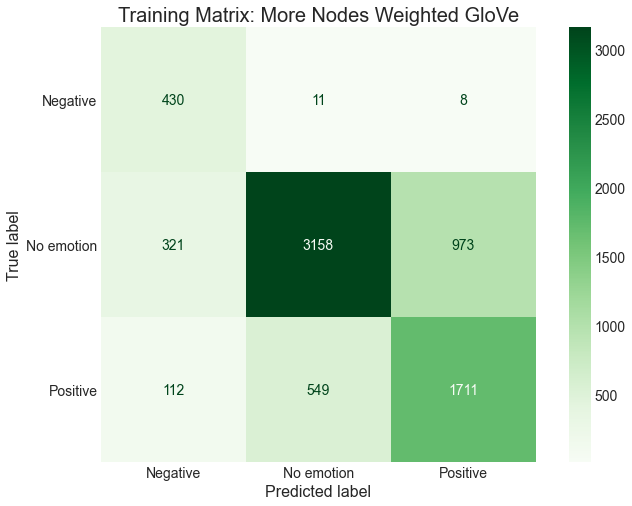

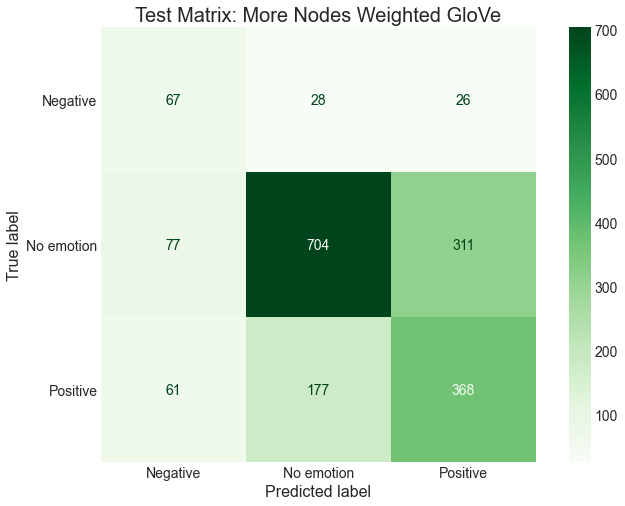

In [91]:
viz.make_network_confusion_matrices(w_more_lstm_rnn,
                                   X_train_padded,
                                   y_train_rnn,
                                   X_test_padded,
                                   y_test_rnn,
                                   labels = label.classes_,
                                   title = 'More Nodes Weighted GloVe')

There are signs of overfitting starting around 10 epochs.

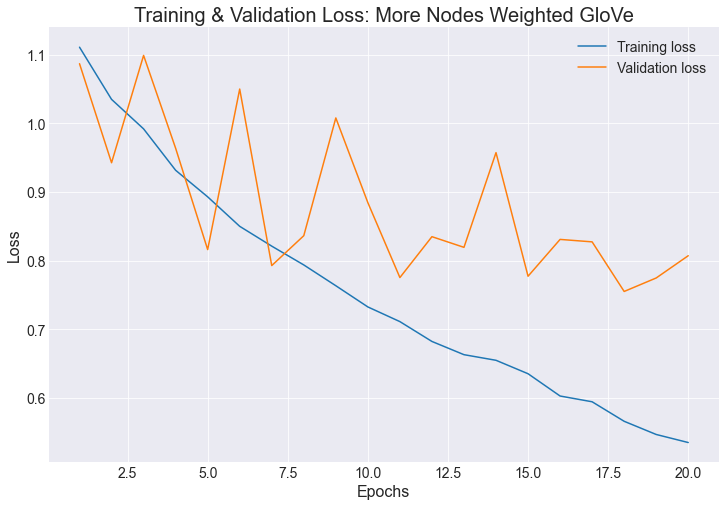

In [92]:
viz.training_graph(w_more_lstm_rnn_val_dict, 'More Nodes Weighted GloVe')

### Increasing Embedding Size

Let's try to increase the number of embedding dimensions to see if more meaning can be gleaned from the data that way.

In [93]:
more_embed_rnn = Sequential()
embedding_size = 256
more_embed_rnn.add(embedding_layer)
more_embed_rnn.add(LSTM(50, return_sequences=True))
more_embed_rnn.add(GlobalMaxPool1D())
more_embed_rnn.add(Dropout(0.5))
more_embed_rnn.add(Dense(50, activation='relu'))
more_embed_rnn.add(Dropout(0.5))
more_embed_rnn.add(Dense(3, activation='softmax'))
more_embed_rnn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [94]:
more_embed_rnn_val = more_embed_rnn.fit(X_train_padded,
                                      y_train_rnn,
                                        epochs=15, 
                                      batch_size=32,
                                      validation_split=0.1)

Epoch 1/15
205/205 [==============================] - 7s 28ms/step - loss: 0.8917 - accuracy: 0.5748 - val_loss: 0.7892 - val_accuracy: 0.6511
Epoch 2/15
205/205 [==============================] - 6s 27ms/step - loss: 0.8387 - accuracy: 0.6040 - val_loss: 0.7660 - val_accuracy: 0.6511
Epoch 3/15
205/205 [==============================] - 6s 27ms/step - loss: 0.8167 - accuracy: 0.6148 - val_loss: 0.7683 - val_accuracy: 0.6662
Epoch 4/15
205/205 [==============================] - 5s 27ms/step - loss: 0.7882 - accuracy: 0.6338 - val_loss: 0.7387 - val_accuracy: 0.6676
Epoch 5/15
205/205 [==============================] - 6s 27ms/step - loss: 0.7670 - accuracy: 0.6429 - val_loss: 0.7024 - val_accuracy: 0.7088
Epoch 6/15
205/205 [==============================] - 6s 27ms/step - loss: 0.7393 - accuracy: 0.6604 - val_loss: 0.6986 - val_accuracy: 0.7060
Epoch 7/15
205/205 [==============================] - 5s 26ms/step - loss: 0.7199 - accuracy: 0.6710 - val_loss: 0.6918 - val_accuracy: 0.7088

In [95]:
more_embed_rnn_val_dict = more_embed_rnn_val.history

#### Metrics

This model also doesn't seem to perform significantly better than the original RNN model.

In [96]:
more_embed_metrics = dp.get_network_metrics(more_embed_rnn, 
                                          X_train_padded, 
                                          y_train_rnn, 
                                          X_test_padded,
                                          y_test_rnn)

228/228 [==============================] - 2s 9ms/step - loss: 0.5425 - accuracy: 0.7691
----------
Training Loss: 0.542 
Training Accuracy: 0.769
Train Average Weighted F1 Score: 0.758
Train Recall on Rarest Category: 0.301
Train Precision on Rarest Category: 0.714
Train F1 on Rarest Category: 0.423
57/57 [==============================] - 1s 9ms/step - loss: 0.7099 - accuracy: 0.6861
----------
Test Loss: 0.71 
Test Accuracy: 0.686
Test Average Weighted F1 Score: 0.67
Test Recall on Rarest Category: 0.207
Test Precision on Rarest Category: 0.735
Test F1 on Rarest Category: 0.323


#### Confusion Matrices

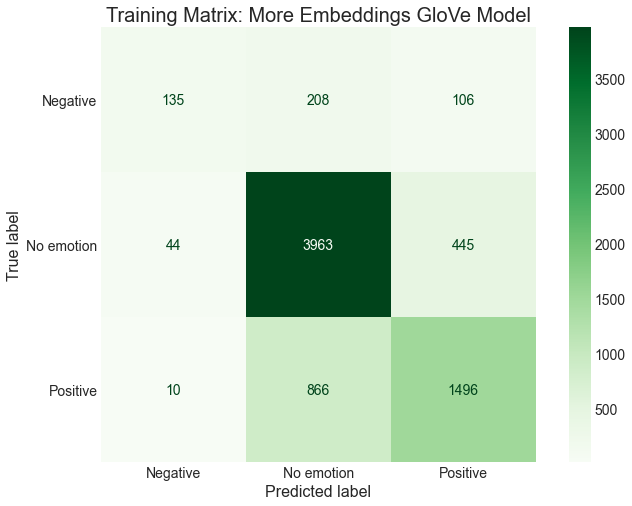

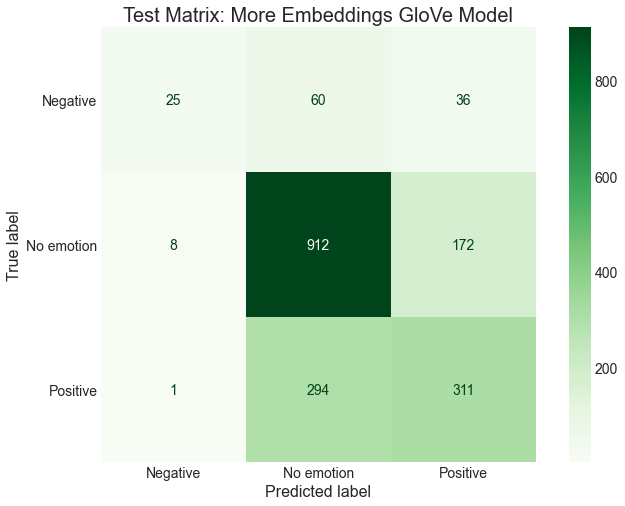

In [97]:
viz.make_network_confusion_matrices(more_embed_rnn,
                                   X_train_padded,
                                   y_train_rnn,
                                   X_test_padded,
                                   y_test_rnn,
                                   labels = label.classes_,
                                   title = 'More Embeddings GloVe Model')

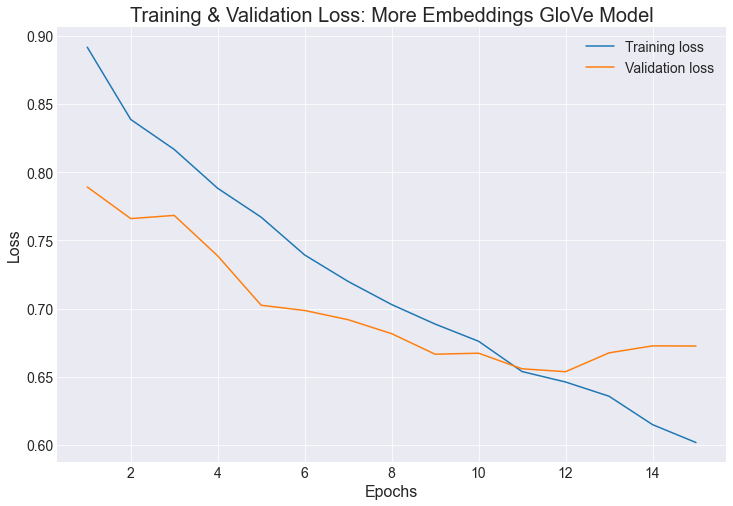

In [98]:
viz.training_graph(more_embed_rnn_val_dict, 'More Embeddings GloVe Model')

### *Adding Weighting*

In [99]:
w_more_embed_rnn = Sequential()
embedding_size = 256
w_more_embed_rnn.add(embedding_layer)
w_more_embed_rnn.add(LSTM(50, return_sequences=True))
w_more_embed_rnn.add(GlobalMaxPool1D())
w_more_embed_rnn.add(Dropout(0.5))
w_more_embed_rnn.add(Dense(50, activation='relu'))
w_more_embed_rnn.add(Dropout(0.5))
w_more_embed_rnn.add(Dense(3, activation='softmax'))
w_more_embed_rnn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [100]:
w_more_embed_rnn_val = w_more_embed_rnn.fit(X_train_padded,
                                          y_train_rnn,
                                            epochs=25, 
                                          batch_size=32,
                                          validation_split=0.1,
                                           class_weight= d_class_weights)

Epoch 1/25
205/205 [==============================] - 8s 29ms/step - loss: 1.1055 - accuracy: 0.3620 - val_loss: 1.1398 - val_accuracy: 0.2019
Epoch 2/25
205/205 [==============================] - 6s 28ms/step - loss: 1.0433 - accuracy: 0.4078 - val_loss: 0.9532 - val_accuracy: 0.5646
Epoch 3/25
205/205 [==============================] - 6s 27ms/step - loss: 0.9897 - accuracy: 0.4636 - val_loss: 0.9855 - val_accuracy: 0.4959
Epoch 4/25
205/205 [==============================] - 6s 27ms/step - loss: 0.9351 - accuracy: 0.4778 - val_loss: 0.8420 - val_accuracy: 0.6415
Epoch 5/25
205/205 [==============================] - 6s 27ms/step - loss: 0.9040 - accuracy: 0.5236 - val_loss: 0.8752 - val_accuracy: 0.5962
Epoch 6/25
205/205 [==============================] - 6s 28ms/step - loss: 0.8544 - accuracy: 0.5435 - val_loss: 0.8432 - val_accuracy: 0.6250
Epoch 7/25
205/205 [==============================] - 6s 27ms/step - loss: 0.8393 - accuracy: 0.5557 - val_loss: 0.8972 - val_accuracy: 0.5824

In [101]:
w_more_embed_rnn_val_dict = w_more_embed_rnn_val.history

#### Metrics

Performs similarly to the others, but better than the unweighted version. Doesn't do as well as the previous weighted model on the rare category.

In [102]:
w_more_embed_metrics = dp.get_network_metrics(w_more_embed_rnn, 
                                          X_train_padded, 
                                          y_train_rnn, 
                                          X_test_padded,
                                          y_test_rnn)

228/228 [==============================] - 2s 9ms/step - loss: 0.5800 - accuracy: 0.7449
----------
Training Loss: 0.58 
Training Accuracy: 0.745
Train Average Weighted F1 Score: 0.748
Train Recall on Rarest Category: 0.951
Train Precision on Rarest Category: 0.558
Train F1 on Rarest Category: 0.703
57/57 [==============================] - 1s 9ms/step - loss: 0.7923 - accuracy: 0.6520
----------
Test Loss: 0.792 
Test Accuracy: 0.652
Test Average Weighted F1 Score: 0.658
Test Recall on Rarest Category: 0.554
Test Precision on Rarest Category: 0.385
Test F1 on Rarest Category: 0.454


#### Confusion Matrices

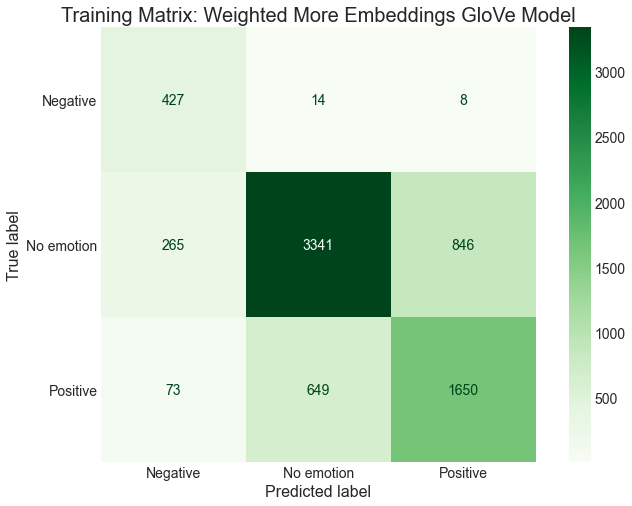

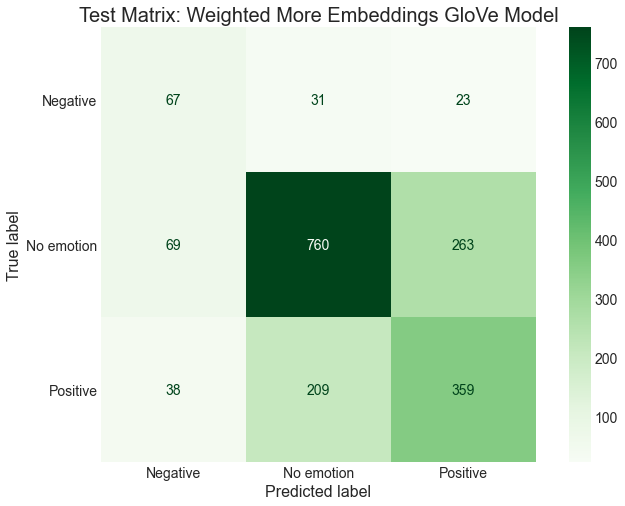

In [103]:
viz.make_network_confusion_matrices(w_more_embed_rnn,
                                   X_train_padded,
                                   y_train_rnn,
                                   X_test_padded,
                                   y_test_rnn,
                                   labels = label.classes_,
                                   title = 'Weighted More Embeddings GloVe Model')

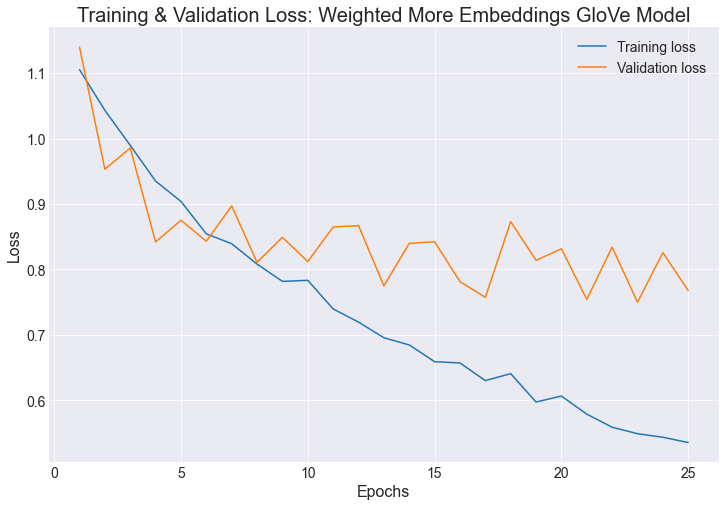

In [104]:
viz.training_graph(w_more_embed_rnn_val_dict, 'Weighted More Embeddings GloVe Model')

### Adding Depth

Let's try making the network deeper to see if that helps.

In [105]:
deeper_rnn = Sequential()
embedding_size = 128
deeper_rnn.add(embedding_layer)
deeper_rnn.add(LSTM(50, return_sequences=True))
deeper_rnn.add(Dropout(0.5))
deeper_rnn.add(LSTM(50, return_sequences=True))
deeper_rnn.add(GlobalMaxPool1D())
deeper_rnn.add(Dropout(0.5))
deeper_rnn.add(Dense(50, activation='relu'))
deeper_rnn.add(Dropout(0.5))
deeper_rnn.add(Dense(3, activation='softmax'))
deeper_rnn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [106]:
deeper_rnn_val = deeper_rnn.fit(X_train_padded,
                                y_train_rnn,
                                epochs=15, 
                                batch_size=32,
                                validation_split=0.1)

Epoch 1/15
205/205 [==============================] - 14s 54ms/step - loss: 0.8956 - accuracy: 0.5749 - val_loss: 0.8065 - val_accuracy: 0.6511
Epoch 2/15
205/205 [==============================] - 10s 50ms/step - loss: 0.8383 - accuracy: 0.6072 - val_loss: 0.7651 - val_accuracy: 0.6566
Epoch 3/15
205/205 [==============================] - 11s 53ms/step - loss: 0.8062 - accuracy: 0.6170 - val_loss: 0.7432 - val_accuracy: 0.6552
Epoch 4/15
205/205 [==============================] - 11s 52ms/step - loss: 0.7805 - accuracy: 0.6226 - val_loss: 0.7159 - val_accuracy: 0.6923
Epoch 5/15
205/205 [==============================] - 10s 51ms/step - loss: 0.7588 - accuracy: 0.6420 - val_loss: 0.6937 - val_accuracy: 0.6909
Epoch 6/15
205/205 [==============================] - 10s 51ms/step - loss: 0.7285 - accuracy: 0.6611 - val_loss: 0.6799 - val_accuracy: 0.7129
Epoch 7/15
205/205 [==============================] - 10s 51ms/step - loss: 0.7024 - accuracy: 0.6735 - val_loss: 0.6914 - val_accuracy:

In [107]:
deeper_rnn_val_dict = deeper_rnn_val.history

#### Metrics

The deeper model performed marginally better with F1 score than the baseline model. The model doesn't do well on the rare category.

In [108]:
deeper_rnn_metrics = dp.get_network_metrics(deeper_rnn, 
                                          X_train_padded, 
                                          y_train_rnn, 
                                          X_test_padded,
                                          y_test_rnn)

228/228 [==============================] - 4s 16ms/step - loss: 0.4976 - accuracy: 0.7852
----------
Training Loss: 0.498 
Training Accuracy: 0.785
Train Average Weighted F1 Score: 0.777
Train Recall on Rarest Category: 0.408
Train Precision on Rarest Category: 0.813
Train F1 on Rarest Category: 0.543
57/57 [==============================] - 1s 16ms/step - loss: 0.7389 - accuracy: 0.6905
----------
Test Loss: 0.739 
Test Accuracy: 0.69
Test Average Weighted F1 Score: 0.675
Test Recall on Rarest Category: 0.19
Test Precision on Rarest Category: 0.59
Test F1 on Rarest Category: 0.288


#### Confusion Matrices

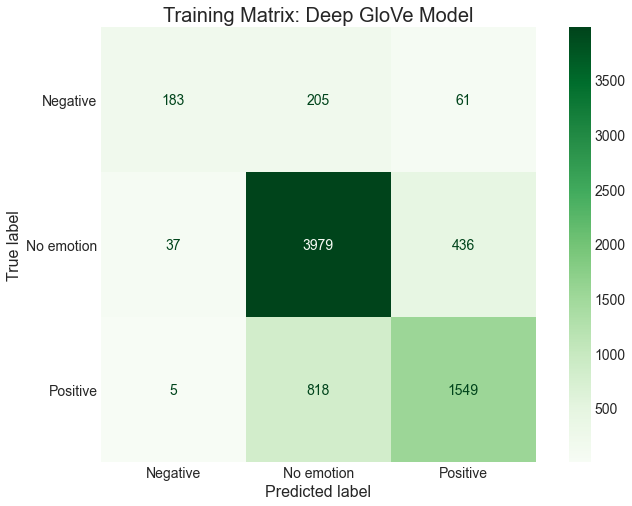

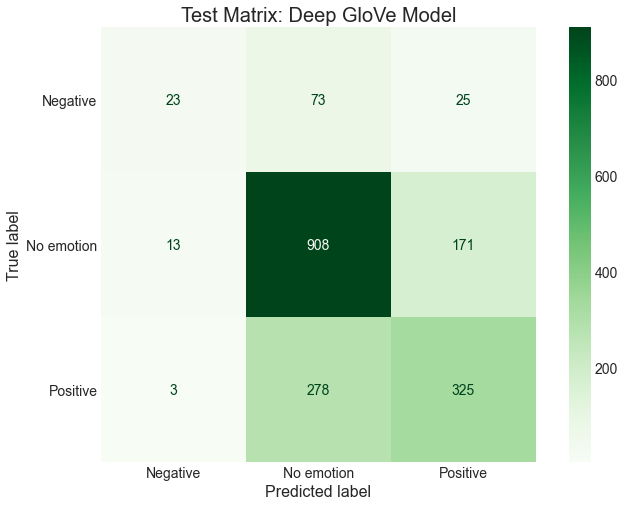

In [109]:
viz.make_network_confusion_matrices(deeper_rnn,
                                   X_train_padded,
                                   y_train_rnn,
                                   X_test_padded,
                                   y_test_rnn,
                                   labels = label.classes_,
                                   title = 'Deep GloVe Model')


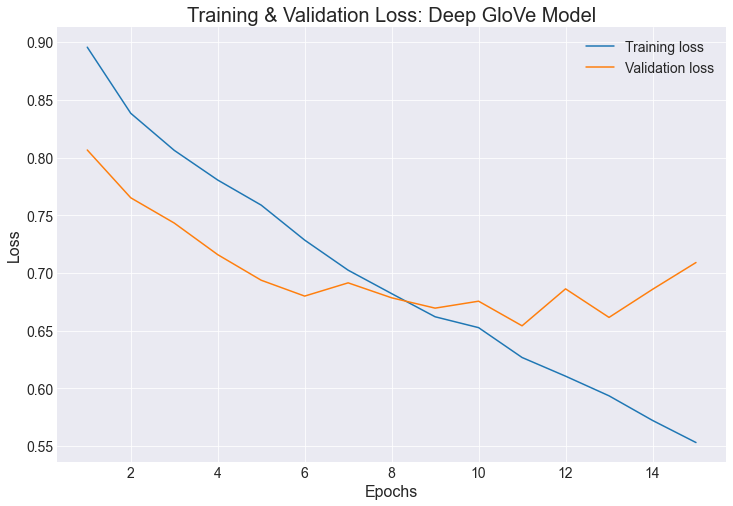

In [110]:
viz.training_graph(deeper_rnn_val_dict, 'Deep GloVe Model')

### *Adding Weights*

In [111]:
w_deeper_rnn = Sequential()
embedding_size = 128
w_deeper_rnn.add(embedding_layer)
w_deeper_rnn.add(LSTM(50, return_sequences=True))
w_deeper_rnn.add(Dropout(0.5))
w_deeper_rnn.add(LSTM(50, return_sequences=True))
w_deeper_rnn.add(GlobalMaxPool1D())
w_deeper_rnn.add(Dropout(0.5))
w_deeper_rnn.add(Dense(50, activation='relu'))
w_deeper_rnn.add(Dropout(0.5))
w_deeper_rnn.add(Dense(3, activation='softmax'))
w_deeper_rnn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [112]:
w_deeper_rnn_val = w_deeper_rnn.fit(X_train_padded,
                                y_train_rnn,
                                epochs=20, 
                                batch_size=32,
                                validation_split=0.1,
                               class_weight= d_class_weights)

Epoch 1/20
205/205 [==============================] - 14s 54ms/step - loss: 1.1021 - accuracy: 0.3537 - val_loss: 1.0030 - val_accuracy: 0.5343
Epoch 2/20
205/205 [==============================] - 10s 51ms/step - loss: 1.0624 - accuracy: 0.3711 - val_loss: 0.9998 - val_accuracy: 0.5151
Epoch 3/20
205/205 [==============================] - 10s 50ms/step - loss: 1.0024 - accuracy: 0.4428 - val_loss: 1.1838 - val_accuracy: 0.3420
Epoch 4/20
205/205 [==============================] - 11s 51ms/step - loss: 0.9384 - accuracy: 0.4978 - val_loss: 0.9549 - val_accuracy: 0.5536
Epoch 5/20
205/205 [==============================] - 10s 51ms/step - loss: 0.8744 - accuracy: 0.5248 - val_loss: 0.8973 - val_accuracy: 0.5865
Epoch 6/20
205/205 [==============================] - 10s 50ms/step - loss: 0.8404 - accuracy: 0.5740 - val_loss: 0.7885 - val_accuracy: 0.6607
Epoch 7/20
205/205 [==============================] - 10s 51ms/step - loss: 0.8044 - accuracy: 0.5853 - val_loss: 0.8598 - val_accuracy:

In [113]:
w_deeper_rnn_val_dict = w_deeper_rnn_val.history

#### Metrics

Doesn't do better than other weighted models on F1 or accuracy, but does very well on recall for rare category.

In [114]:
w_deeper_metrics = dp.get_network_metrics(w_deeper_rnn, 
                                          X_train_padded, 
                                          y_train_rnn, 
                                          X_test_padded,
                                          y_test_rnn)

228/228 [==============================] - 4s 17ms/step - loss: 0.5710 - accuracy: 0.7504
----------
Training Loss: 0.571 
Training Accuracy: 0.75
Train Average Weighted F1 Score: 0.752
Train Recall on Rarest Category: 0.927
Train Precision on Rarest Category: 0.684
Train F1 on Rarest Category: 0.787
57/57 [==============================] - 1s 17ms/step - loss: 0.8327 - accuracy: 0.6658
----------
Test Loss: 0.833 
Test Accuracy: 0.666
Test Average Weighted F1 Score: 0.669
Test Recall on Rarest Category: 0.463
Test Precision on Rarest Category: 0.452
Test F1 on Rarest Category: 0.457


#### Confusion Matrices

But even those this model has high recall on the rare data, it comes at the cost of a lot of false positives, and a clearly low precision.

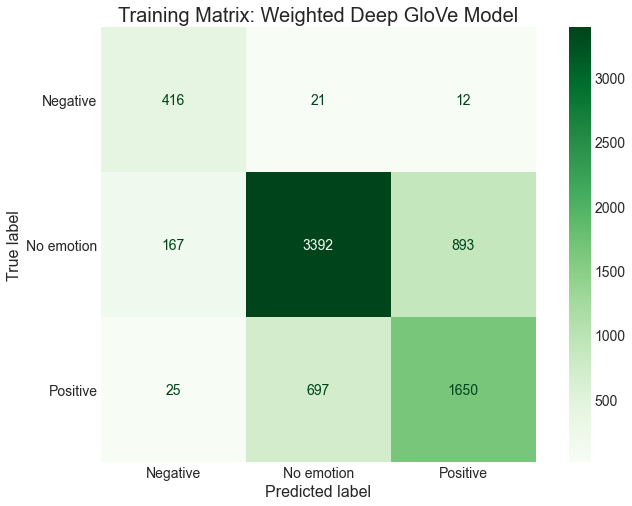

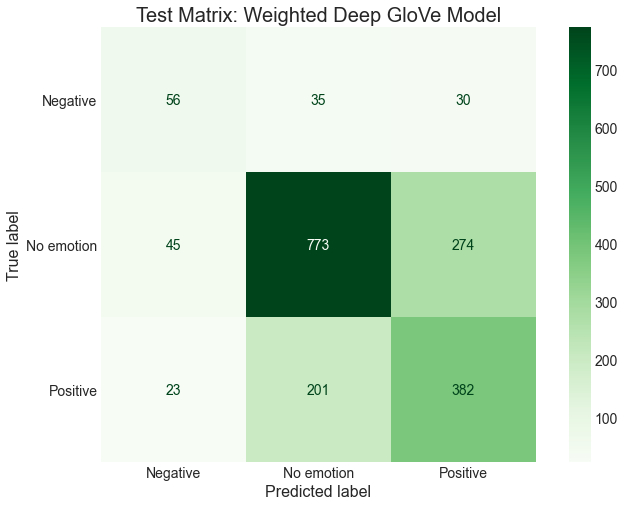

In [115]:
viz.make_network_confusion_matrices(w_deeper_rnn,
                                   X_train_padded,
                                   y_train_rnn,
                                   X_test_padded,
                                   y_test_rnn,
                                   labels = label.classes_,
                                   title = 'Weighted Deep GloVe Model')

Clear signs of overfitting around the 8th epoch.

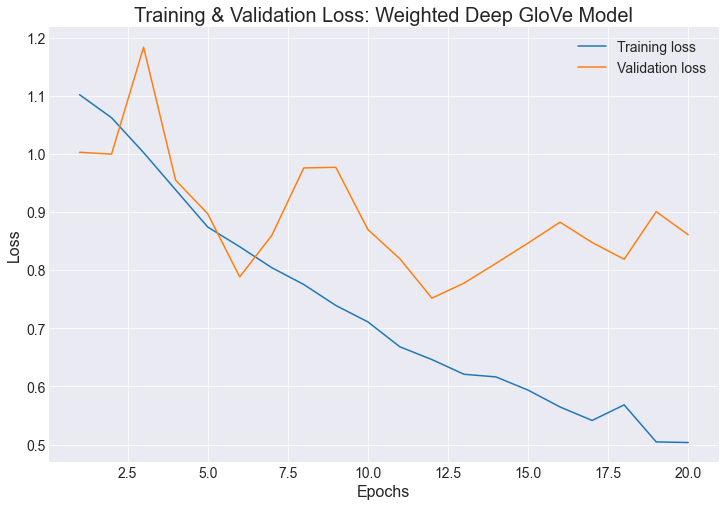

In [116]:
viz.training_graph(w_deeper_rnn_val_dict, 'Weighted Deep GloVe Model')

### *Even Deeper*

In [117]:
deepest_rnn = Sequential()
embedding_size = 128
deepest_rnn.add(embedding_layer)
deepest_rnn.add(LSTM(50, return_sequences=True))
deepest_rnn.add(Dropout(0.5))
deepest_rnn.add(LSTM(50, return_sequences=True))
deepest_rnn.add(Dropout(0.5))
deepest_rnn.add(LSTM(50, return_sequences=True))
deepest_rnn.add(GlobalMaxPool1D())
deepest_rnn.add(Dropout(0.5))
deepest_rnn.add(Dense(50, activation='relu'))
deepest_rnn.add(Dropout(0.5))
deepest_rnn.add(Dense(3, activation='softmax'))
deepest_rnn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])


In [118]:
deepest_rnn_val = deepest_rnn.fit(X_train_padded,
                                y_train_rnn,
                                epochs=12, 
                                batch_size=32,
                                validation_split=0.1)

Epoch 1/12
205/205 [==============================] - 20s 80ms/step - loss: 0.8906 - accuracy: 0.5869 - val_loss: 0.7925 - val_accuracy: 0.6511
Epoch 2/12
205/205 [==============================] - 16s 77ms/step - loss: 0.8303 - accuracy: 0.6099 - val_loss: 0.7853 - val_accuracy: 0.6484
Epoch 3/12
205/205 [==============================] - 16s 78ms/step - loss: 0.8079 - accuracy: 0.6116 - val_loss: 0.7864 - val_accuracy: 0.6511
Epoch 4/12
205/205 [==============================] - 16s 77ms/step - loss: 0.7835 - accuracy: 0.6263 - val_loss: 0.7373 - val_accuracy: 0.6717
Epoch 5/12
205/205 [==============================] - 16s 77ms/step - loss: 0.7562 - accuracy: 0.6489 - val_loss: 0.7394 - val_accuracy: 0.6484
Epoch 6/12
205/205 [==============================] - 16s 77ms/step - loss: 0.7316 - accuracy: 0.6613 - val_loss: 0.7109 - val_accuracy: 0.6676
Epoch 7/12
205/205 [==============================] - 16s 77ms/step - loss: 0.6997 - accuracy: 0.6842 - val_loss: 0.6933 - val_accuracy:

In [119]:
deepest_rnn_val_dict = deepest_rnn_val.history

#### Metrics

Does well on accuracy but more poorly on F1 score than baseline. Does poorly with the rare data.

In [120]:
deepest_metrics = dp.get_network_metrics(deepest_rnn, 
                                          X_train_padded, 
                                          y_train_rnn, 
                                          X_test_padded,
                                          y_test_rnn)

228/228 [==============================] - 6s 24ms/step - loss: 0.5348 - accuracy: 0.7722
----------
Training Loss: 0.535 
Training Accuracy: 0.772
Train Average Weighted F1 Score: 0.771
Train Recall on Rarest Category: 0.57
Train Precision on Rarest Category: 0.674
Train F1 on Rarest Category: 0.618
57/57 [==============================] - 1s 24ms/step - loss: 0.7414 - accuracy: 0.6625
----------
Test Loss: 0.741 
Test Accuracy: 0.662
Test Average Weighted F1 Score: 0.658
Test Recall on Rarest Category: 0.273
Test Precision on Rarest Category: 0.471
Test F1 on Rarest Category: 0.346


#### Confusion Matrices

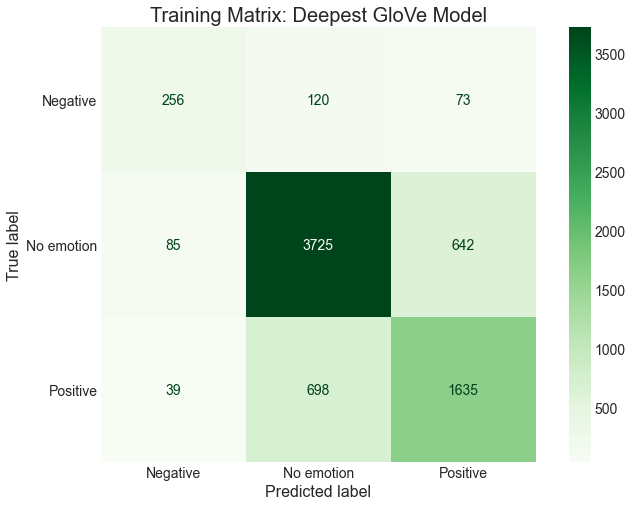

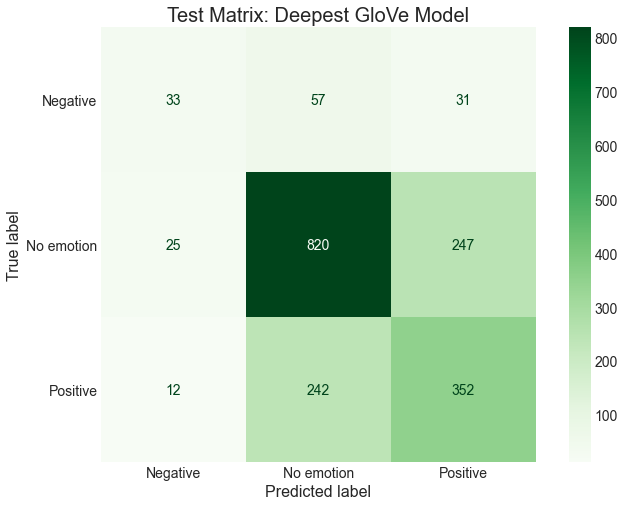

In [121]:
viz.make_network_confusion_matrices(deepest_rnn,
                                   X_train_padded,
                                   y_train_rnn,
                                   X_test_padded,
                                   y_test_rnn,
                                   labels = label.classes_,
                                   title = 'Deepest GloVe Model')

Validation is plateauing a bit, but no clear signs of major overfitting.

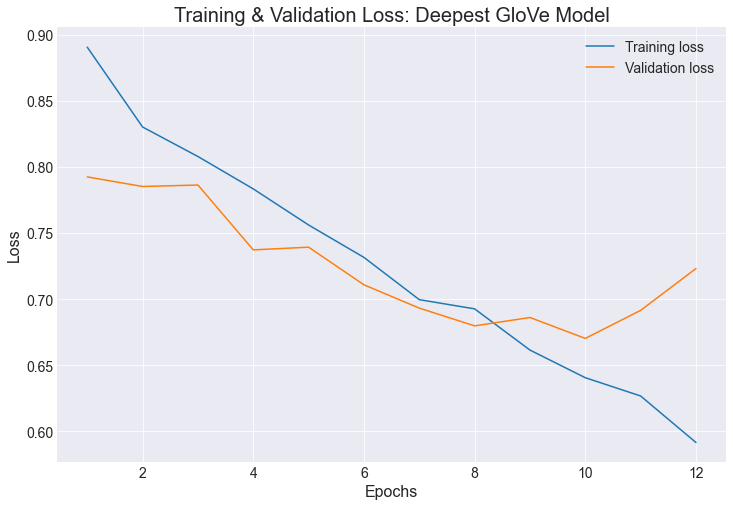

In [122]:
viz.training_graph(deepest_rnn_val_dict, 'Deepest GloVe Model')

### *Adding Weights*

In [123]:
w_deepest_rnn = Sequential()
embedding_size = 128
w_deepest_rnn.add(embedding_layer)
w_deepest_rnn.add(LSTM(50, return_sequences=True))
w_deepest_rnn.add(Dropout(0.5))
w_deepest_rnn.add(LSTM(50, return_sequences=True))
w_deepest_rnn.add(Dropout(0.5))
w_deepest_rnn.add(LSTM(50, return_sequences=True))
w_deepest_rnn.add(GlobalMaxPool1D())
w_deepest_rnn.add(Dropout(0.5))
w_deepest_rnn.add(Dense(50, activation='relu'))
w_deepest_rnn.add(Dropout(0.5))
w_deepest_rnn.add(Dense(3, activation='softmax'))
w_deepest_rnn.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])


In [124]:
w_deepest_rnn_val = w_deepest_rnn.fit(X_train_padded,
                                y_train_rnn,
                                epochs=25, 
                                batch_size=32,
                                validation_split=0.1,
                               class_weight= d_class_weights)

Epoch 1/25
205/205 [==============================] - 21s 82ms/step - loss: 1.1036 - accuracy: 0.3679 - val_loss: 1.0098 - val_accuracy: 0.5247
Epoch 2/25
205/205 [==============================] - 16s 79ms/step - loss: 1.0500 - accuracy: 0.3838 - val_loss: 1.0703 - val_accuracy: 0.4080
Epoch 3/25
205/205 [==============================] - 16s 79ms/step - loss: 0.9989 - accuracy: 0.4454 - val_loss: 1.0599 - val_accuracy: 0.3654
Epoch 4/25
205/205 [==============================] - 17s 81ms/step - loss: 0.9506 - accuracy: 0.4698 - val_loss: 0.9037 - val_accuracy: 0.6099
Epoch 5/25
205/205 [==============================] - 17s 81ms/step - loss: 0.8983 - accuracy: 0.5149 - val_loss: 0.9447 - val_accuracy: 0.5412
Epoch 6/25
205/205 [==============================] - 17s 82ms/step - loss: 0.8515 - accuracy: 0.5341 - val_loss: 0.8863 - val_accuracy: 0.5755
Epoch 7/25
205/205 [==============================] - 18s 87ms/step - loss: 0.8239 - accuracy: 0.5451 - val_loss: 0.9737 - val_accuracy:

In [125]:
w_deepest_rnn_val_dict = w_deepest_rnn_val.history

#### Metrics

Does poorly on F1 and accuracy and has poor recall compared to previous weighted models.

In [126]:
w_deepest_metrics = dp.get_network_metrics(w_deepest_rnn, 
                                          X_train_padded, 
                                          y_train_rnn, 
                                          X_test_padded,
                                          y_test_rnn)

228/228 [==============================] - 7s 29ms/step - loss: 0.5561 - accuracy: 0.7598
----------
Training Loss: 0.556 
Training Accuracy: 0.76
Train Average Weighted F1 Score: 0.76
Train Recall on Rarest Category: 0.938
Train Precision on Rarest Category: 0.687
Train F1 on Rarest Category: 0.793
57/57 [==============================] - 2s 27ms/step - loss: 0.8844 - accuracy: 0.6548
----------
Test Loss: 0.884 
Test Accuracy: 0.655
Test Average Weighted F1 Score: 0.657
Test Recall on Rarest Category: 0.43
Test Precision on Rarest Category: 0.46
Test F1 on Rarest Category: 0.444


#### Confusion Matrices

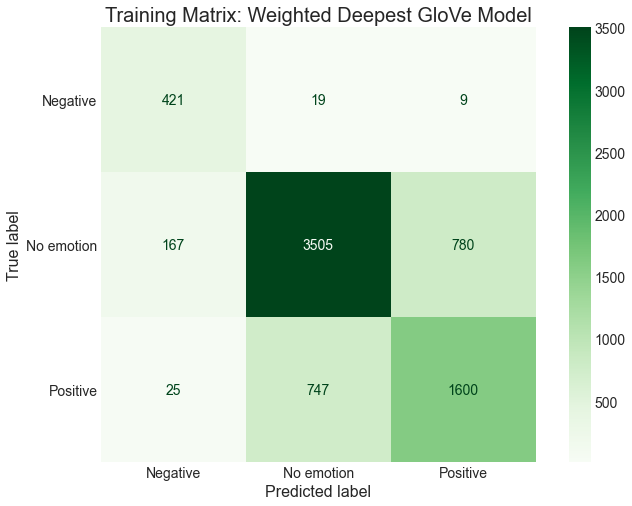

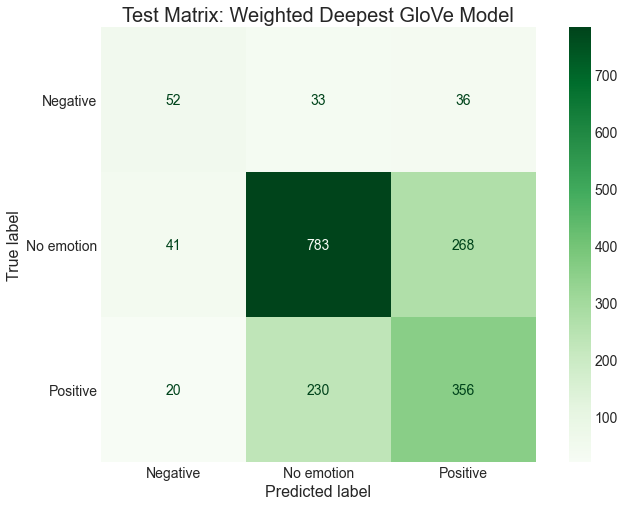

In [127]:
viz.make_network_confusion_matrices(w_deepest_rnn,
                                   X_train_padded,
                                   y_train_rnn,
                                   X_test_padded,
                                   y_test_rnn,
                                   labels = label.classes_,
                                   title = 'Weighted Deepest GloVe Model')


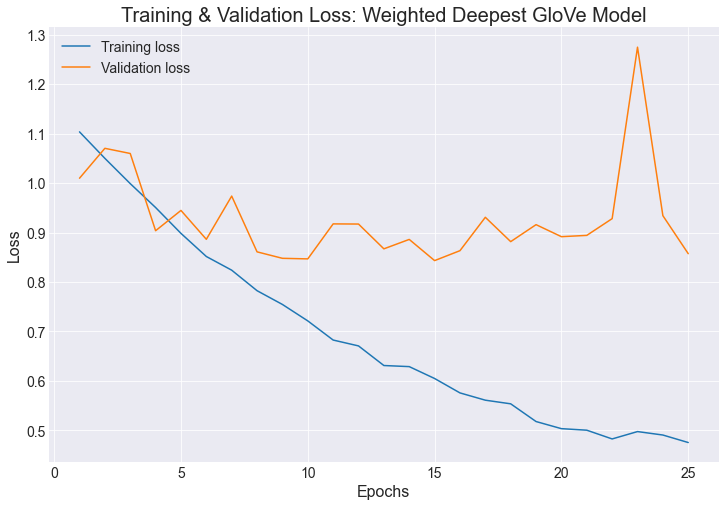

In [128]:
viz.training_graph(w_deepest_rnn_val_dict, 'Weighted Deepest GloVe Model')

## Picking a Final Model

To help pick which model is best, let's graph some of the metrics of the models.

In [129]:
baseline_metrics['Test F1']

0.6614740870307808

In [130]:
F1_scores = {'Baseline (3 layer)': [baseline_metrics['Test F1']],
             'Weighted': [weighted_metrics['Test F1']],
             'Augmented': [augmented_metrics['Test F1']],
             'Baseline GloVe': [glove_metrics['Test F1']],
             'Weighted GloVe': [wglove_metrics['Test F1']],
             'More Nodes': [more_lstm_metrics['Test F1']],
             'Weighted More Nodes': [w_more_lstm_metrics['Test F1']],
             'More Embedding': [more_embed_metrics['Test F1']],
             'Weighted More Embedding': [w_more_embed_metrics['Test F1']],
             '4 layer': [deeper_rnn_metrics['Test F1']],
             'Weighted 4 layer': [w_deeper_metrics['Test F1']],
             '5 layer': [deepest_metrics['Test F1']],
             'Weighted 5 layer': [w_deepest_metrics['Test F1']]}

F1_df = pd.DataFrame.from_dict(F1_scores, orient='index')
F1_df.columns = ['F1 Score']

In [131]:
F1_df

F1 Score
Baseline (3 layer)       0.661474
Weighted                 0.627725
Augmented                0.657272
Baseline GloVe           0.682884
Weighted GloVe           0.624492
More Nodes               0.682424
Weighted More Nodes      0.636795
More Embedding           0.670030
Weighted More Embedding  0.657610
4 layer                  0.674987
Weighted 4 layer         0.669158
5 layer                  0.658034
Weighted 5 layer         0.656646

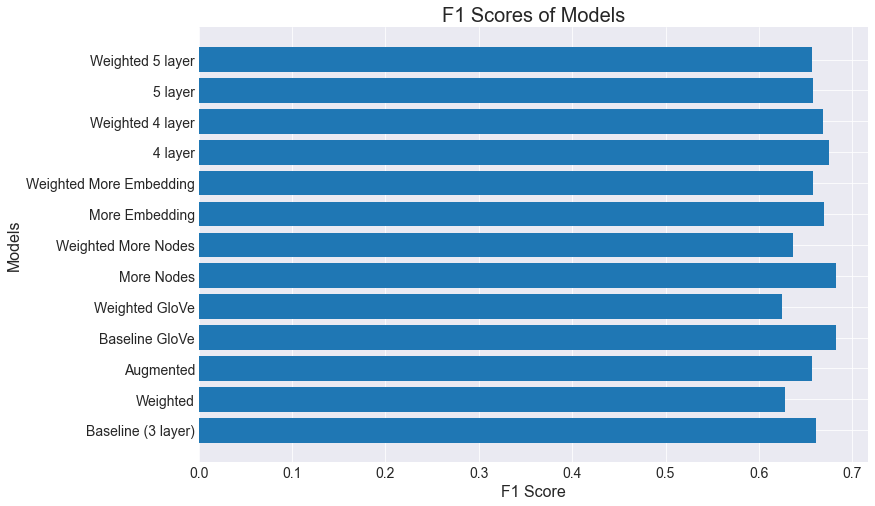

In [132]:
plt.barh(F1_df.index, F1_df['F1 Score'])
plt.title('F1 Scores of Models')
plt.xlabel('F1 Score')
plt.ylabel('Models')
plt.show()

In [133]:
Neg_Recall = {'Baseline': [baseline_metrics['Test Rare Recall']],
             'Weighted': [weighted_metrics['Test Rare Recall']],
             'Augmented': [augmented_metrics['Test Rare Recall']],
             'Baseline GloVe': [glove_metrics['Test Rare Recall']],
             'Weighted GloVe': [wglove_metrics['Test Rare Recall']],
             'More Nodes': [more_lstm_metrics['Test Rare Recall']],
             'Weighted More Nodes': [w_more_lstm_metrics['Test Rare Recall']],
             'More Embedding': [more_embed_metrics['Test Rare Recall']],
             'Weighted More Embedding': [w_more_embed_metrics['Test Rare Recall']],
             '4 layer': [deeper_rnn_metrics['Test Rare Recall']],
             'Weighted 4 layer': [w_deeper_metrics['Test Rare Recall']],
             '5 layer': [deepest_metrics['Test Rare Recall']],
             'Weighted 5 layer': [w_deepest_metrics['Test Rare Recall']]
            }
Recall_df = pd.DataFrame.from_dict(Neg_Recall, orient='index')
Recall_df.columns = ['Rare Recall']

In [134]:
Recall_df.head()

Rare Recall
Baseline           0.322314
Weighted           0.471074
Augmented          0.314050
Baseline GloVe     0.280992
Weighted GloVe     0.545455

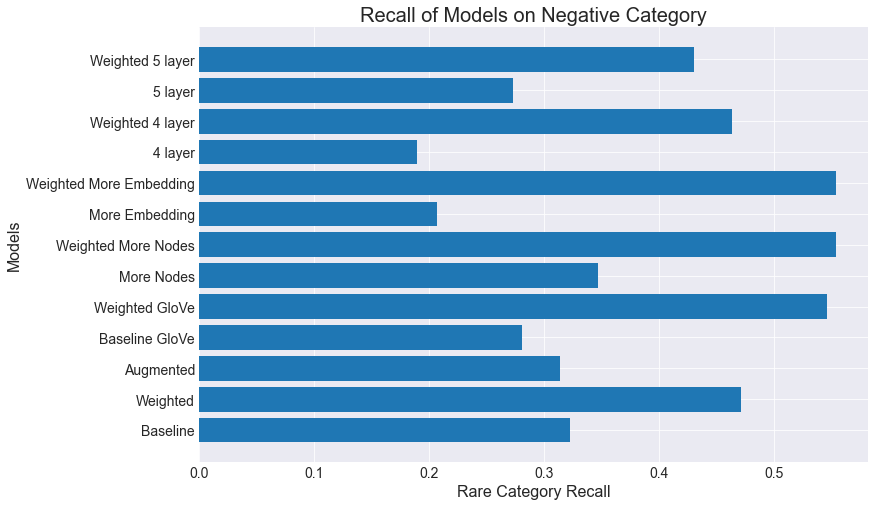

In [135]:
plt.barh(Recall_df.index, Recall_df['Rare Recall'])
plt.title('Recall of Models on Negative Category')
plt.xlabel('Rare Category Recall')
plt.ylabel('Models')
plt.show()

In [136]:
Neg_F1 = {'Baseline': [baseline_metrics['Test Rare F1']],
          'Weighted': [weighted_metrics['Test Rare F1']],
          'Augmented': [augmented_metrics['Test Rare F1']],
          'Baseline GloVe': [glove_metrics['Test Rare F1']],
          'Weighted GloVe': [wglove_metrics['Test Rare F1']],
          'More Nodes': [more_lstm_metrics['Test Rare F1']],
          'Weighted More Nodes': [w_more_lstm_metrics['Test Rare F1']],
          'More Embedding': [more_embed_metrics['Test Rare F1']],
          'Weighted More Embedding': [w_more_embed_metrics['Test Rare F1']],
          '4 layer': [deeper_rnn_metrics['Test Rare F1']],
          'Weighted 4 layer': [w_deeper_metrics['Test Rare F1']],
          '5 layer': [deepest_metrics['Test Rare F1']],
          'Weighted 5 layer': [w_deepest_metrics['Test Rare F1']]}
Rare_F1_df = pd.DataFrame.from_dict(Neg_F1, orient='index')
Rare_F1_df.columns = ['Rare F1']

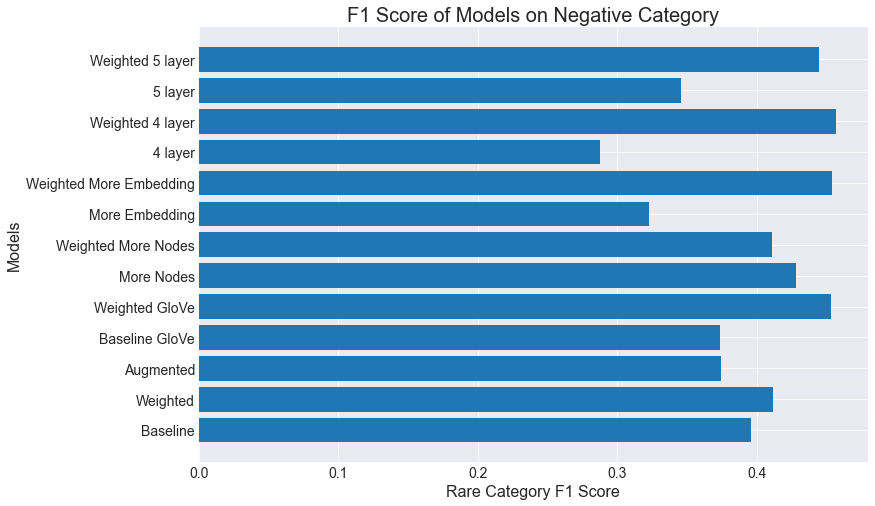

In [137]:
plt.barh(Rare_F1_df.index, Rare_F1_df['Rare F1'])
plt.title('F1 Score of Models on Negative Category')
plt.xlabel('Rare Category F1 Score')
plt.ylabel('Models')
plt.show()

In [138]:
Acc = {'Baseline': [baseline_metrics['Test Accuracy']],
          'Weighted': [weighted_metrics['Test Accuracy']],
          'Augmented': [augmented_metrics['Test Accuracy']],
          'Baseline GloVe': [glove_metrics['Test Accuracy']],
          'Weighted GloVe': [wglove_metrics['Test Accuracy']],
          'More Nodes': [more_lstm_metrics['Test Accuracy']],
          'Weighted More Nodes': [w_more_lstm_metrics['Test Accuracy']],
          'More Embedding': [more_embed_metrics['Test Accuracy']],
          'Weighted More Embedding': [w_more_embed_metrics['Test Accuracy']],
          '4 layer': [deeper_rnn_metrics['Test Accuracy']],
          'Weighted 4 layer': [w_deeper_metrics['Test Accuracy']],
          '5 layer': [deepest_metrics['Test Accuracy']],
          'Weighted 5 layer': [w_deepest_metrics['Test Accuracy']]}
Acc_df = pd.DataFrame.from_dict(Acc, orient='index')
Acc_df.columns = ['Accuracy']

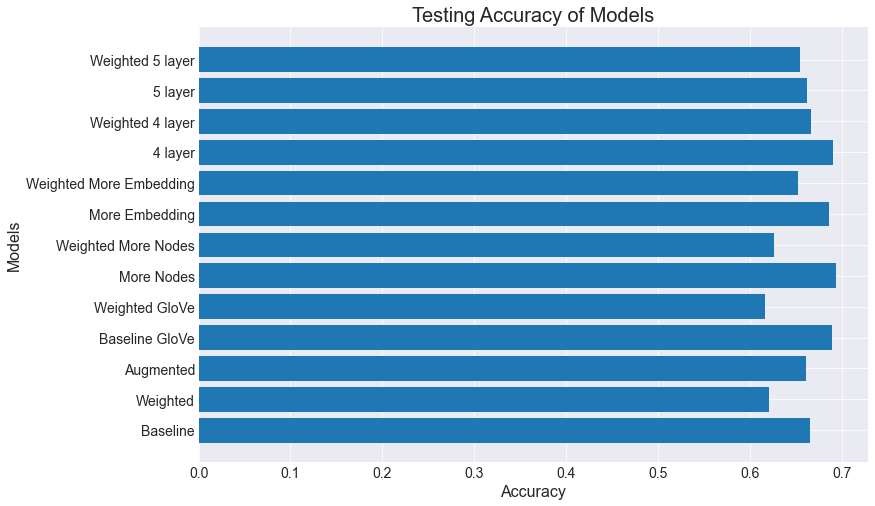

In [139]:
plt.barh(Acc_df.index, Acc_df['Accuracy'])
plt.title('Testing Accuracy of Models')
plt.xlabel('Accuracy')
plt.ylabel('Models')
plt.show()

Preceding under the assumption that we don't have special reason to care more about performance on the rare category, we will pick the Baseline GloVe model as the final model since it has the heighted weighted F1 score as well as the highest accuracy. It is however fairly middle of the pack in performance on the negative category and has quite low recall on that category.

In [140]:
# Throws warning, but reloaded model works
glove_rnn.save('models/final_model')

INFO:tensorflow:Assets written to: models/final_model\assets


INFO:tensorflow:Assets written to: models/final_model\assets


In [141]:
final_model = keras.models.load_model('models/final_model')

In [142]:
final_model_metrics = dp.get_network_metrics(final_model, 
                                          X_train_padded, 
                                          y_train_rnn, 
                                          X_test_padded,
                                          y_test_rnn)

228/228 [==============================] - 3s 12ms/step - loss: 0.4791 - accuracy: 0.8078
----------
Training Loss: 0.479 
Training Accuracy: 0.808
Train Average Weighted F1 Score: 0.805
Train Recall on Rarest Category: 0.586
Train Precision on Rarest Category: 0.756
Train F1 on Rarest Category: 0.66
57/57 [==============================] - 1s 12ms/step - loss: 0.7223 - accuracy: 0.6894
----------
Test Loss: 0.722 
Test Accuracy: 0.689
Test Average Weighted F1 Score: 0.683
Test Recall on Rarest Category: 0.281
Test Precision on Rarest Category: 0.557
Test F1 on Rarest Category: 0.374


Let's create a version of the final model wrapped in a sklearn pipeline. This will help us make the Keras model compatible with useful interpretative tools such as Lime.

In [143]:
class custom_tokenizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.tokenizer = text.Tokenizer(num_words=20000)
    
    def fit(self, X, y=None):
        self.tokenizer.fit_on_texts(list(X))
        return self
    
    def transform(self, X, y=None, *_):
        tokenized_list = self.tokenizer.texts_to_sequences(X)
        X_padded = sequence.pad_sequences(tokenized_list, maxlen=100)
        return X_padded
    
    def fit_transform(self, X, y=None, *_):
        self.tokenizer.fit_on_texts(list(X))
        tokenized_list = self.tokenizer.texts_to_sequences(X)
        X_padded = sequence.pad_sequences(tokenized_list, maxlen=100)
        return X_padded

In [144]:
def create_final_model():
    final_model = Sequential()
    final_model.add(embedding_layer)
    final_model.add(LSTM(50, return_sequences=True))
    final_model.add(GlobalMaxPool1D())
    final_model.add(Dropout(0.5))
    final_model.add(Dense(50, activation='relu'))
    final_model.add(Dropout(0.5))
    final_model.add(Dense(3, activation='softmax'))
    final_model.compile(loss='categorical_crossentropy', 
                        optimizer='adam', 
                        metrics=['accuracy'])
    return final_model

In [145]:
wrapped_model = KerasClassifier(build_fn=create_final_model, verbose=1)

<ipython-input-145-d3e670fe2f6b>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  wrapped_model = KerasClassifier(build_fn=create_final_model, verbose=1)


In [146]:
pipe = Pipeline([
                ('tokenizer', custom_tokenizer()),
                ('model', wrapped_model)
])

In [147]:
pipe_val = pipe.fit(X = X_train,
                    y = y_train_rnn,
                    model__epochs=20, 
                    model__batch_size=32,
                    model__validation_split=0.1)

Epoch 1/20
205/205 [==============================] - 8s 31ms/step - loss: 0.8936 - accuracy: 0.5731 - val_loss: 0.7988 - val_accuracy: 0.6511
Epoch 2/20
205/205 [==============================] - 6s 29ms/step - loss: 0.8325 - accuracy: 0.6064 - val_loss: 0.7570 - val_accuracy: 0.6511
Epoch 3/20
205/205 [==============================] - 6s 31ms/step - loss: 0.8078 - accuracy: 0.6165 - val_loss: 0.7540 - val_accuracy: 0.6799
Epoch 4/20
205/205 [==============================] - 6s 29ms/step - loss: 0.7824 - accuracy: 0.6289 - val_loss: 0.7245 - val_accuracy: 0.6964
Epoch 5/20
205/205 [==============================] - 6s 29ms/step - loss: 0.7595 - accuracy: 0.6475 - val_loss: 0.7359 - val_accuracy: 0.6772
Epoch 6/20
205/205 [==============================] - 6s 29ms/step - loss: 0.7374 - accuracy: 0.6652 - val_loss: 0.6918 - val_accuracy: 0.6951
Epoch 7/20
205/205 [==============================] - 6s 31ms/step - loss: 0.7225 - accuracy: 0.6684 - val_loss: 0.6887 - val_accuracy: 0.7019

Finally, let's add a column in the data with the model's predictions.

In [148]:
clean['final_predict'] = pipe.predict(clean['cleaned_text'])
clean['final_predict'] = clean['final_predict'].apply(lambda x: label.classes_[x])

In [149]:
clean.head()

tweet_text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1  @jessedee Know about @fludapp ? Awesome iPad/i...   
2  @swonderlin Can not wait for #iPad 2 also. The...   
3  @sxsw I hope this year's festival isn't as cra...   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...   

  emotion_in_tweet_is_directed_at  \
0                          iPhone   
1              iPad or iPhone App   
2                            iPad   
3              iPad or iPhone App   
4                          Google   

  is_there_an_emotion_directed_at_a_brand_or_product  \
0                                           Negative   
1                                           Positive   
2                                           Positive   
3                                           Negative   
4                                           Positive   

                                        cleaned_text  \
0    i have a 3g iphone  after 3 hrs tweeting at ...   
1   know about    awesome ipad iphone app that yo...   
2   can not wait for ipad 2 also  they should sal...   
3   i hope this years festival is not as crashy a...   
4   great stuff on fri   marissa mayer  google   ...   

                                        tokened_text  \
0  [3g, iphone, 3, hr, tweeting, rise_austin, wa,...   
1  [know, awesome, ipad, iphone, app, likely, app...   
2                        [wait, ipad, 2, also, sale]   
3  [hope, year, festival, crashy, year, iphone, app]   
4  [great, stuff, fri, marissa, mayer, google, ti...   

                                        no_stop_text final_predict  
0  3g iphone 3 hr tweeting rise_austin wa dead ne...    No emotion  
1  know awesome ipad iphone app likely appreciate...      Positive  
2                              wait ipad 2 also sale    No emotion  
3          hope year festival crashy year iphone app    No emotion  
4  great stuff fri marissa mayer google tim oreil...      Positive

## Interpreting Models

Let's compare the bayesian, forest and final model using Lime to give us an idea of what words or features the model is putting emphasis on.

In [150]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

In [151]:
explainer = LimeTextExplainer(class_names=label.classes_)

In [152]:
data = clean['cleaned_text']
targets = clean['is_there_an_emotion_directed_at_a_brand_or_product']

#### *Naive Bayesian Interpretation*

In [153]:
nb = make_pipeline(tfidf, bayes_model)

As we can see below the Bayesian model got this example wrong.

In [154]:
clean['nb_predict'] = nb.predict(clean['cleaned_text'])
clean['nb_predict'] = clean['nb_predict'].apply(lambda x: label.classes_[x])

In [155]:
idx = 170
exp_nb = explainer.explain_instance(data[idx], nb.predict_proba, labels=[0, 1, 2])
print('Index: %d' % idx)
print('Predicted class =', clean['nb_predict'][idx])
print('True class: %s' % targets[idx])

Index: 170
Predicted class = No emotion
True class: Negative


We can use Lime to show us how each individual word affects the probability of the prediction.

In [156]:
exp_nb.show_in_notebook(text=data[idx])

As we can see the model doesn't even notice the word "crashing", nor the sarcastic "seriously".

#### *Random Forest Interpretation*

In [157]:
forest = make_pipeline(tfidf, forest_model)

We can see that the forest model also got this example wrong, but in a different way.

In [158]:
clean['forest_predict'] = forest.predict(clean['cleaned_text'])
clean['forest_predict'] = clean['forest_predict'].apply(lambda x: label.classes_[x])

In [159]:
idx = 170
exp_forest = explainer.explain_instance(data[idx], forest.predict_proba, labels=[0, 1, 2])
print('Index: %d' % idx)
print('Predicted class: ', clean['forest_predict'][idx])
print('True class: %s' % targets[idx])

Index: 170
Predicted class:  No emotion
True class: Negative


We can see below that the forest model is also paying attention to irrelevant words.

In [160]:
exp_forest.show_in_notebook(text=data[idx])

#### *RNN Interpretation*

As we can see the final RNN model correctly predicts this tweet's sentiment.

In [161]:
idx = 170
exp_pipe = explainer.explain_instance(data[idx], pipe.predict_proba, labels=[0, 1, 2])
print('Index: %d' % idx)
print('Predicted class: ', clean['final_predict'][idx])
print('True class: %s' % targets[idx])

Index: 170
Predicted class:  Negative
True class: Negative


We can also get an idea as to why. It seems to correctly identify that "crashing", "seriously", and lost are negative words, and lets it reasonably assign a very high probability to this tweet being negative.

In [162]:
exp_pipe.show_in_notebook(text=data[idx])

# Conclusion

The RNN built here is quite limited with only an accuracy at identifying sentiment of around 68%, but is clearly picking up on the right kinds of features. With more data, it should be possible to get significantly improved performance on this task from a RNN.

That said, even as it stands this model could prove quite useful as a general way to roughly gauge public sentiment when used in combination with the Twitter API.

In [163]:
time.time() - t0 

2349.8955538272858